In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# # Interactive plots
# %matplotlib notebook

# Load all packages used
import matplotlib.pyplot as plt
import numpy as np
import mypackage

TensorFlow version is 2.1.0


Using TensorFlow backend.


In [2]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra", only_with_contaminant=False)

enlarged_X, enlarged_Y = mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=32, sample_multiplication=7, contaminant_type=3)

X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(enlarged_X, enlarged_Y, testRatio=0.3)

X_test, X_train, scaler = mypackage.Dataset.scale(X_test, X_train, scaler='GlobalStandardization')

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)

[0. 1. 2.] (72, 32, 32, 1) (-4.724162179570249, 9.051048341053539) (72, 32, 32, 208) (166, 32, 32, 208)


In [114]:
import tensorflow.keras.backend as K
# Similar code here: https://analysiscenter.github.io/radio/_modules/radio/models/keras/losses.html      
#          and here: https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html
# Code from: https://github.com/keras-team/keras/issues/9395
# Ref: salehi17, "Twersky loss function for image segmentation using 2D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # probability that voxels are class i
    p1 = ones-y_pred # probability that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    # Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    Ncl = 1
    return Ncl - T

X_input (166, 32, 32, 208, 1), Y_input (166, 32, 32, 3)
Train on 149 samples, validate on 17 samples
Epoch 1/30
145/149 [============================>.] - ETA: 0s - loss: 0.7880 - accuracy: 0.6619
Epoch 00001: val_loss improved from inf to 0.80278, saving model to best-model.hdf5
149/149 [==============================] - 16s 107ms/sample - loss: 0.7874 - accuracy: 0.6677 - val_loss: 0.8028 - val_accuracy: 0.9528
Epoch 2/30
145/149 [============================>.] - ETA: 0s - loss: 0.7558 - accuracy: 0.9099
Epoch 00002: val_loss improved from 0.80278 to 0.79549, saving model to best-model.hdf5
149/149 [==============================] - 13s 90ms/sample - loss: 0.7539 - accuracy: 0.9114 - val_loss: 0.7955 - val_accuracy: 0.9722
Epoch 3/30
145/149 [============================>.] - ETA: 0s - loss: 0.7305 - accuracy: 0.9390
Epoch 00003: val_loss improved from 0.79549 to 0.75233, saving model to best-model.hdf5
149/149 [==============================] - 13s 90ms/sample - loss: 0.7301 - accu

Epoch 27/30
145/149 [============================>.] - ETA: 0s - loss: 0.5296 - accuracy: 0.9779
Epoch 00027: val_loss did not improve from 0.51345
149/149 [==============================] - 13s 90ms/sample - loss: 0.5292 - accuracy: 0.9783 - val_loss: 0.5152 - val_accuracy: 0.9842
Epoch 28/30
145/149 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.9788
Epoch 00028: val_loss improved from 0.51345 to 0.51192, saving model to best-model.hdf5
149/149 [==============================] - 13s 90ms/sample - loss: 0.5276 - accuracy: 0.9788 - val_loss: 0.5119 - val_accuracy: 0.9883
Epoch 29/30
145/149 [============================>.] - ETA: 0s - loss: 0.5433 - accuracy: 0.9729
Epoch 00029: val_loss improved from 0.51192 to 0.51175, saving model to best-model.hdf5
149/149 [==============================] - 13s 90ms/sample - loss: 0.5426 - accuracy: 0.9732 - val_loss: 0.5118 - val_accuracy: 0.9879
Epoch 30/30
145/149 [============================>.] - ETA: 0s - loss: 0.5259

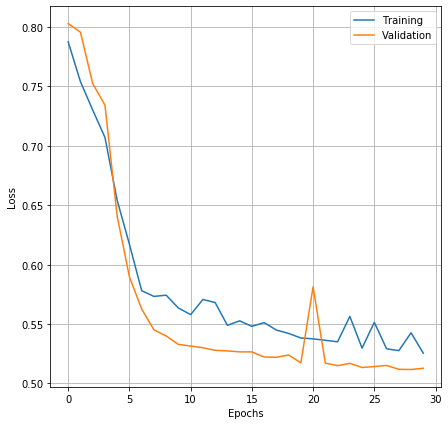

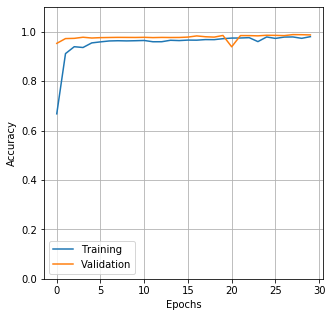

Predicting for train data
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    124488
           1       0.95      0.98      0.97     42195
           2       0.92      0.79      0.85      3301

    accuracy                           0.98    169984
   macro avg       0.96      0.92      0.94    169984
weighted avg       0.98      0.98      0.98    169984



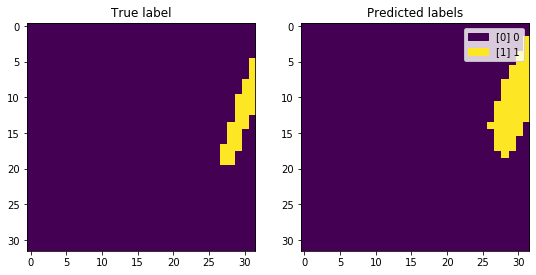

Predicting for test data
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     54369
           1       0.94      0.98      0.96     18218
           2       0.97      0.56      0.71      1141

    accuracy                           0.98     73728
   macro avg       0.97      0.84      0.89     73728
weighted avg       0.98      0.98      0.98     73728



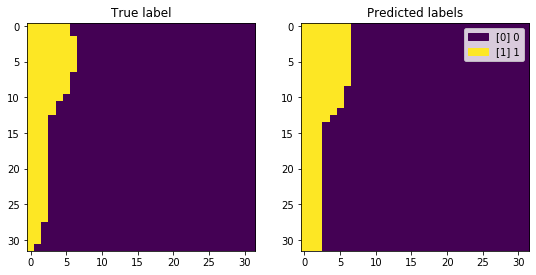

In [3]:
import tensorflow as tf
import tensorflow.keras.backend as K

def tversky_loss(y_true, y_pred, alpha=0.3, beta=0.7, smooth=1e-10, numb_classes=2):
    """ Tversky loss function.

    Parameters
    ----------
    y_true : keras tensor
        tensor containing target mask.
    y_pred : keras tensor
        tensor containing predicted mask.
    alpha : float
        real value, weight of '0' class.
    beta : float
        real value, weight of '1' class.
    smooth : float
        small real value used for avoiding division by zero error.

    Returns
    -------
    keras tensor
        tensor containing tversky loss.
    """
    def join_classes(y):
        # The expected input contains the labels [0, 1, 2]
        # This function maps 0->0, 1->0 and 2->1
        if numb_classes == 3: # Ignores no class
            return y / 3      # It worked well for all classes for a specific(ally) good dataset
        if numb_classes == 2: # This ignores the background. This should be enough to classify all well.
            return y[...,1:] / 2
        else:
            return y[...,2:] # Ignores all except contaminants
    
    # K.permute_dimensions(y_true, (3,1,2,0))
#     tf.print(K.shape(y_true))
#     tf.print(K.shape(y_true[..., 0:2]))
#     tf.print(K.flatten(y_true))
    #     tf.print(K.flatten(map_to_binary(y_true)))
    #     y_new = np.zeros((K.shape(y_true)[:-1], 2))
    #     y_new[..., 0] = y_true[..., 0] + y_true[..., 1]
    #     y_new[..., 1] = y_true[..., 1]
    
    y_true = K.flatten(join_classes(y_true))
    y_pred = K.flatten(join_classes(y_pred))
    truepos = K.sum(y_true * y_pred)
    fp_and_fn = alpha * K.sum(y_pred * (1 - y_true)) + beta * K.sum((1 - y_pred) * y_true)
    answer = (truepos + smooth) / ((truepos + smooth) + fp_and_fn)
#     tf.print(y_true)
#     tf.print(y_pred)
    return 1 - answer

# X_train[i:i+2], Y_train[i:i+2]
unet = mypackage.MyUnet.UNet(X_train, Y_train, loss_func=tversky_loss)
unet.train(batch_size=5, epochs=30, validation_split=0.1, clear_output=False, monitor='val_loss', mode='min')
# unet.summary()
unet.plot_training_results()
print("Predicting for train data")
unet.predict(X_train, Y_labels=Y_train)
print("Predicting for test data")
unet.predict(X_test, Y_labels=Y_test);

In [4]:
tl = lambda y_true, y_pred: tversky_loss(y_true, y_pred, numb_classes=1)
unet.retrain(X_train, Y_train, batch_size=5, epochs=20, loss=tl, validation_split=0.1)

Number of layers in the base model:  49
Train on 149 samples, validate on 17 samples
Epoch 1/20
145/149 [============================>.] - ETA: 0s - loss: 0.4494 - accuracy: 0.9708
Epoch 00001: val_loss improved from inf to 0.76965, saving model to best-model.hdf5
149/149 [==============================] - 15s 98ms/sample - loss: 0.4424 - accuracy: 0.9702 - val_loss: 0.7697 - val_accuracy: 0.9770
Epoch 2/20
145/149 [============================>.] - ETA: 0s - loss: 0.4640 - accuracy: 0.9718
Epoch 00002: val_loss improved from 0.76965 to 0.62565, saving model to best-model.hdf5
149/149 [==============================] - 13s 91ms/sample - loss: 0.4691 - accuracy: 0.9716 - val_loss: 0.6256 - val_accuracy: 0.9762
Epoch 3/20
145/149 [============================>.] - ETA: 0s - loss: 0.4216 - accuracy: 0.9756
Epoch 00003: val_loss improved from 0.62565 to 0.58240, saving model to best-model.hdf5
149/149 [==============================] - 13s 89ms/sample - loss: 0.4140 - accuracy: 0.9759 - va

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    124488
           1       0.98      0.95      0.97     42195
           2       0.85      0.96      0.91      3301

    accuracy                           0.98    169984
   macro avg       0.94      0.97      0.95    169984
weighted avg       0.98      0.98      0.98    169984



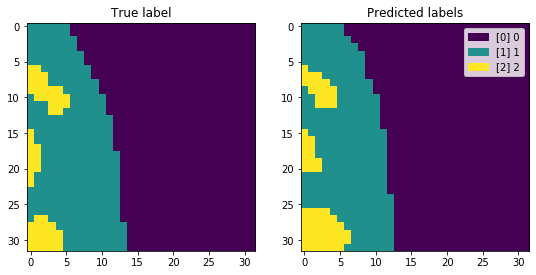

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     54369
           1       0.97      0.95      0.96     18218
           2       0.85      0.70      0.77      1141

    accuracy                           0.98     73728
   macro avg       0.94      0.88      0.91     73728
weighted avg       0.98      0.98      0.98     73728



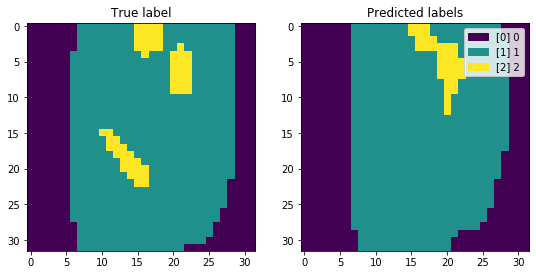

In [7]:
unet.predict(X_train, Y_train);
unet.predict(X_test, Y_test);

In [46]:
for i in range(len(Y_train)):
    print(np.unique(Y_train[i]))

[0. 1.]
[0.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0.]
[0. 1.]
[0. 1. 2.]
[0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1. 2.]
[0.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0.]
[0. 1. 2.]
[0. 1.]
[0.]
[0. 1.]
[0. 1.]
[0.]
[0. 1. 2.]
[0. 1.]
[0.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0.]
[0.]
[0. 1.]
[0.]
[0.]
[0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0.]
[0. 1.]
[0. 1.]
[0.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0.

In [45]:
for i in range(len(Y_test)):
    print(np.unique(Y_test[i]))
    

[0. 1. 2.]
[0. 1. 2.]
[0.]
[0. 1. 2.]
[0.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0.]
[0.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0.]
[0.]
[0. 1.]
[0.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0.]
[0.]
[0. 1.]
[0.]
[0. 1.]
[0. 1.]
[0.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0.]
[0.]
[0. 1. 2.]
[0.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 2.]
[0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0.]
[0. 1. 2.]
[0. 1.]
[0.]
[0. 1.]
[0. 1. 2.]
[0. 1.]
[0.]
[0. 1.]
[0. 1.]


In [141]:
# Dictionary overwrites the previous key-entery
image_centers = {'chicken_01': (27, 58), 'chicken_01': (77, 70), 'chicken_02': (22, 42),
                 'chicken_02': (75, 51), 'chicken_03': (28, 45), 'chicken_03': (75, 72),
                 'chicken_04': (22, 63), 'chicken_04': (70, 79), 'chicken_05': (19, 90),
                 'chicken_05': (80, 90), 'fillet_FM_01': (38, 51), 'fillet_FM_02': (57, 60),
                 'fillet_FM_03': (50, 33), 'fillet_FM_05': (34, 66), 'fillet_FM_06': (31, 68),
                 'fillet_FM_07': (39, 60), 'fillet_FM_08': (37, 64), 'fillet_FM_09': (34, 50),
                 'fillet_FM_10': (37, 54), 'fillet_FM_11': (48, 34), 'fillet_FM_12': (37, 55),
                 'fillet_v2_FM_01': (44, 60), 'fillet_v2_FM_02': (44, 51), 'fillet_v2_FM_03': (26, 46),
                 'fillet_v2_FM_04': (41, 55), 'fillet_v2_FM_05': (34, 70), 'fillet_v2_FM_06': (34, 56),
                 'fillet_v2_FM_07': (31, 65), 'fillet_v2_FM_08': (44, 56), 'fillet_v2_FM_09': (33, 59),
                 'fillet_v2_FM_10': (44, 71), 'fillet_v2_FM_11': (45, 55), 'FM_02': (57, 60),
                 'FM_03': (60, 37), 'FM_04': (72, 54), 'FM_05': (52, 46), 'FM_06': (52, 49),
                 'FM_07': (61, 49), 'FM_08': (42, 55), 'FM_09': (54, 50), 'FM_10': (56, 39),
                 'leg_meat_FM_01': (43, 52), 'leg_meat_FM_02': (36, 72), 'leg_meat_FM_03': (64, 55),
                 'leg_meat_FM_04': (56, 54), 'leg_meat_FM_05': (36, 51), 'leg_meat_FM_06': (43, 59),
                 'leg_meat_FM_07': (48, 54), 'leg_meat_FM_08': (53, 81), 'leg_meat_FM_09': (61, 41),
                 'leg_meat_FM_10': (48, 60), 'leg_meat_FM_11': (53, 55), 'leg_meatside_01': (39, 82),
                 'leg_meatside_02': (44, 69), 'leg_meatside_03': (38, 54), 'leg_meatside_04': (58, 51),
                 'leg_skin_FM_01': (44, 62), 'leg_skin_FM_02': (44, 55), 'leg_skin_FM_03': (32, 56),
                 'leg_skin_FM_04': (39, 63), 'leg_skin_FM_05': (45, 52), 'leg_skin_FM_06': (56, 58),
                 'leg_skin_FM_07': (44, 67), 'leg_skin_FM_08': (46, 55), 'leg_skin_FM_09': (49, 44),
                 'leg_skin_FM_10': (52, 76), 'leg_skin_FM_11': (50, 50), 'leg_skinside_01': (45, 62),
                 'leg_skinside_04': (45, 53), 'leg_skinside_05': (56, 45), 'leg_skinside_12': (52, 56),
                 'leg_skinside_13': (45, 44), 'leg_skinside_22': (59, 64), 'leg_skinside_23': (58, 78)}
file_list = list(image_centers.keys())
dataset_folder = "data/tomra_day1"
X = mypackage.Dataset.load_files(file_list, dataset_folder, with_labels=False)
_, X, _ = mypackage.Dataset.scale(None, X, scaler=scaler)

size = 32
count, _, _, k = X.shape
X_rest = np.zeros((count, size, size, k))
for i, file in enumerate(file_list):
    x, y = image_centers[file]
    X_rest[i] = mypackage.Dataset.zoom_in_on_center(X[i], x, y, size=32)

print((X_rest.min(), X_rest.max()), X_rest.shape)

(-3.089711904525757, 6.401439189910889) (69, 32, 32, 208)


/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

           0       0.29      0.98      0.45      9188
           1       0.38      0.41      0.39     36364
           2       0.40      0.06      0.10     25462
           3       0.00      0.00      0.00      2714

    accuracy                           0.34     73728
   macro avg       0.27      0.36      0.24     73728
weighted avg       0.36      0.34      0.29     73728



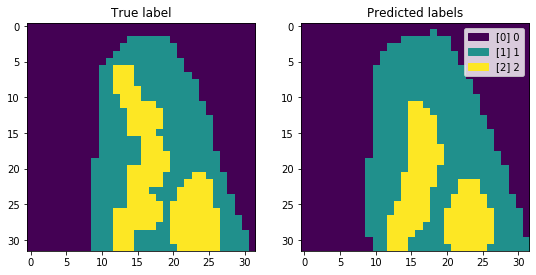

array([[[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [0, 1, 1, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 

In [143]:
unet.predict(X_test, Y_test)

              precision    recall  f1-score   support

           0       0.99      0.93      0.96       278
           1       0.96      0.99      0.97       651
           2       0.95      0.92      0.93        95

    accuracy                           0.96      1024
   macro avg       0.96      0.94      0.95      1024
weighted avg       0.97      0.96      0.96      1024



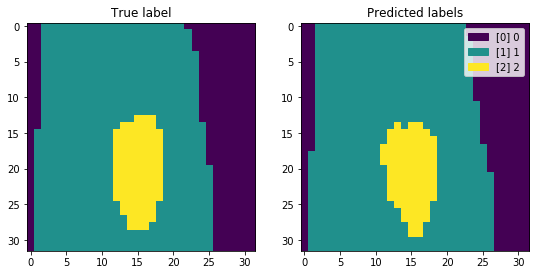

15

In [142]:
unet.predict_only_one(X_test, Y_test)

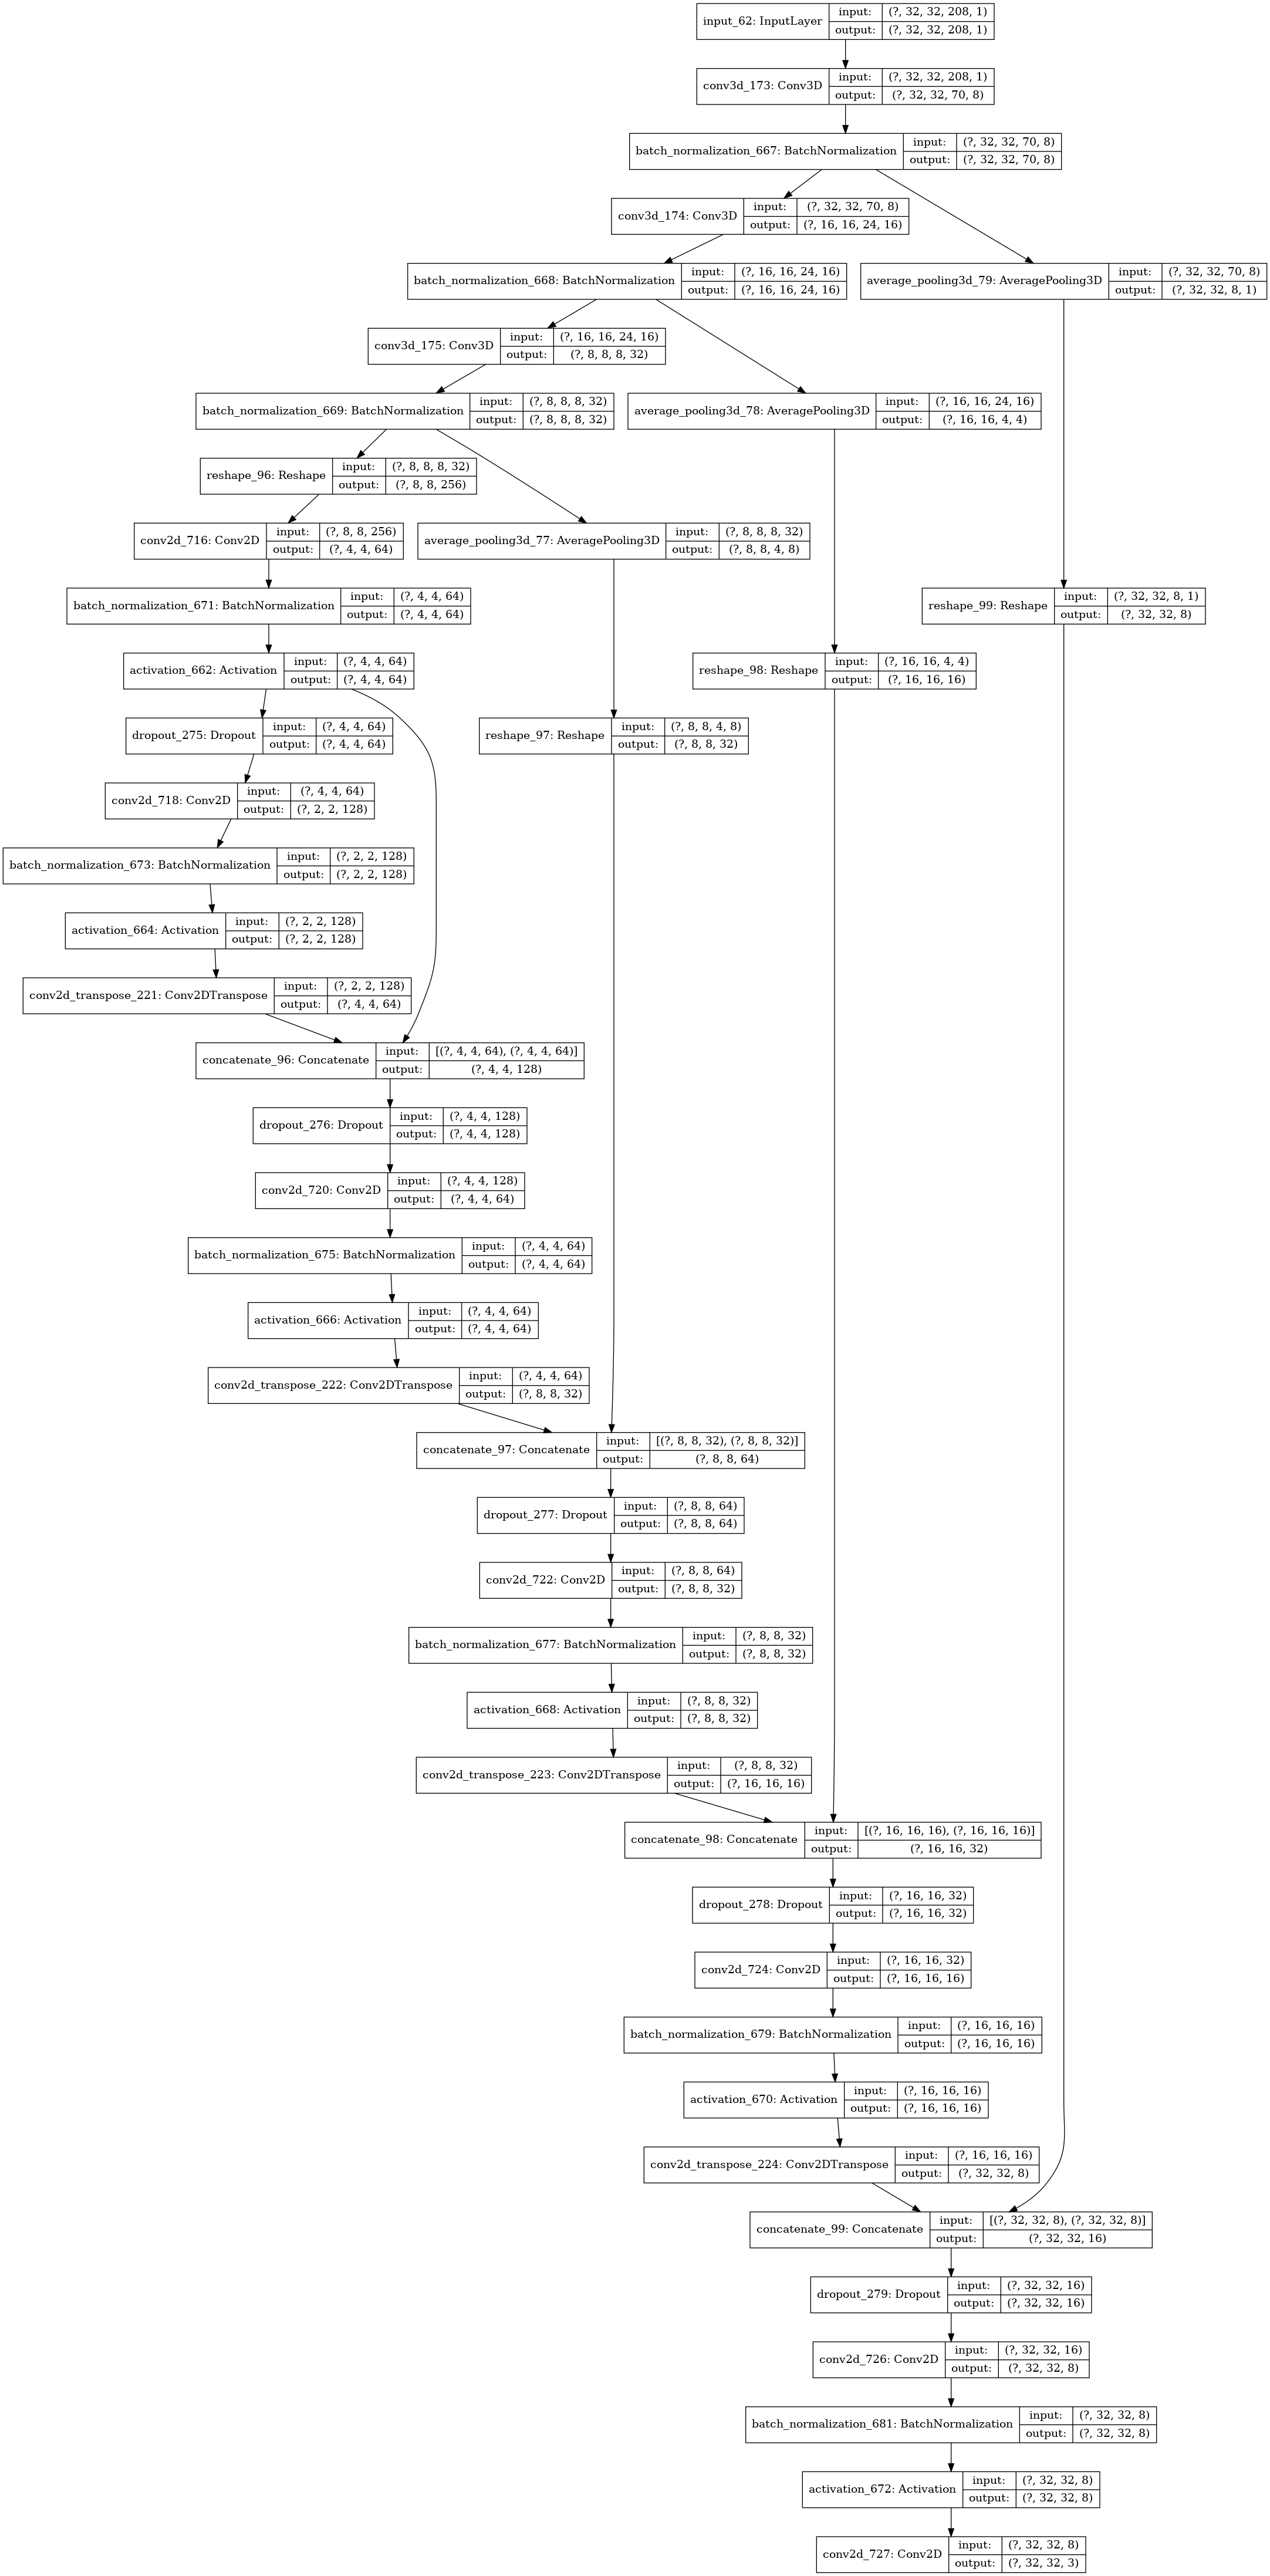

In [117]:
import tensorflow as tf

tf.keras.utils.plot_model(unet.model, show_shapes=True)

[1. 2. 3.] (72, 32, 32, 1) (-3.42214491333501, 7.724653662167159) (72, 32, 32, 208) (166, 32, 32, 208)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 208, 0                                            
__________________________________________________________________________________________________
conv3d_3 (Conv3D)               (None, 32, 32, 70, 8 512         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 32, 32, 70, 8 32          conv3d_3[0][0]                   
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 32, 32, 70, 8 0           batch_normalization_9[0][

Train on 149 samples, validate on 17 samples
Epoch 1/30
145/149 [============================>.] - ETA: 0s - loss: 0.7404 - accuracy: 0.7691
Epoch 00001: val_accuracy improved from -inf to 0.85570, saving model to best-model.hdf5
149/149 [==============================] - 11s 71ms/sample - loss: 0.7363 - accuracy: 0.7722 - val_loss: 0.8837 - val_accuracy: 0.8557
Epoch 2/30
145/149 [============================>.] - ETA: 0s - loss: 0.5588 - accuracy: 0.8941
Epoch 00002: val_accuracy improved from 0.85570 to 0.88448, saving model to best-model.hdf5
149/149 [==============================] - 8s 55ms/sample - loss: 0.5584 - accuracy: 0.8939 - val_loss: 0.7477 - val_accuracy: 0.8845
Epoch 3/30
145/149 [============================>.] - ETA: 0s - loss: 0.4591 - accuracy: 0.9116
Epoch 00003: val_accuracy improved from 0.88448 to 0.89384, saving model to best-model.hdf5
149/149 [==============================] - 8s 55ms/sample - loss: 0.4573 - accuracy: 0.9119 - val_loss: 0.6497 - val_accuracy

Epoch 28/30
145/149 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9791
Epoch 00028: val_accuracy did not improve from 0.96892
149/149 [==============================] - 8s 55ms/sample - loss: 0.0589 - accuracy: 0.9792 - val_loss: 0.0906 - val_accuracy: 0.9669
Epoch 29/30
145/149 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9779
Epoch 00029: val_accuracy improved from 0.96892 to 0.97013, saving model to best-model.hdf5
149/149 [==============================] - 8s 55ms/sample - loss: 0.0652 - accuracy: 0.9780 - val_loss: 0.0852 - val_accuracy: 0.9701
Epoch 30/30
145/149 [============================>.] - ETA: 0s - loss: 0.0546 - accuracy: 0.9810
Epoch 00030: val_accuracy improved from 0.97013 to 0.97070, saving model to best-model.hdf5
149/149 [==============================] - 8s 56ms/sample - loss: 0.0544 - accuracy: 0.9810 - val_loss: 0.0816 - val_accuracy: 0.9707


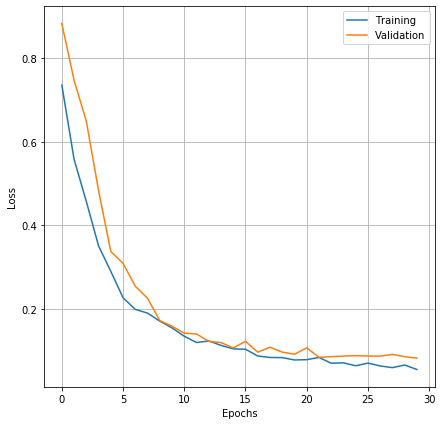

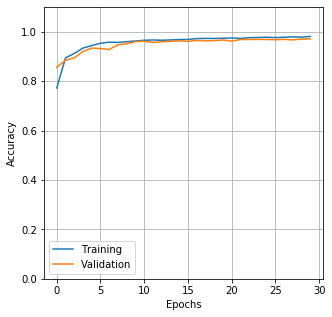

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     26657
           1       0.97      0.98      0.98     41581
           2       0.94      0.84      0.89      5490

    accuracy                           0.97     73728
   macro avg       0.96      0.94      0.95     73728
weighted avg       0.97      0.97      0.97     73728



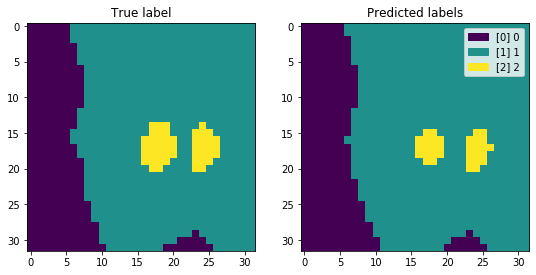

array([[[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 1, 1, ..., 0, 0, 0],
        [0, 1, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0]],

       ...,

       [[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [3]:
# First load the labeled data and train on it
X, Y, info = mypackage.Dataset.load("data/tomra", only_with_contaminant=False)

enlarged_X, enlarged_Y = mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=32, sample_multiplication=7, contaminant_type=3)

X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(enlarged_X, enlarged_Y, testRatio=0.3)

X_test, X_train, scaler = mypackage.Dataset.scale(X_test, X_train, scaler='GlobalStandardization')

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)

unet = mypackage.MyUnet.UNet(X_train, Y_train)
unet.summary()
unet.train(batch_size=5, epochs=30, validation_split=0.1)
unet.plot_training_results()
unet.predict(X_test, Y_labels=Y_test);

In [29]:
# Dictionary overwrites the previous key-entery
image_centers = {'chicken_01': (27, 58), 'chicken_01': (77, 70), 'chicken_02': (22, 42),
                 'chicken_02': (75, 51), 'chicken_03': (28, 45), 'chicken_03': (75, 72),
                 'chicken_04': (22, 63), 'chicken_04': (70, 79), 'chicken_05': (19, 90),
                 'chicken_05': (80, 90), 'fillet_FM_01': (38, 51), 'fillet_FM_02': (57, 60),
                 'fillet_FM_03': (50, 33), 'fillet_FM_05': (34, 66), 'fillet_FM_06': (31, 68),
                 'fillet_FM_07': (39, 60), 'fillet_FM_08': (37, 64), 'fillet_FM_09': (34, 50),
                 'fillet_FM_10': (37, 54), 'fillet_FM_11': (48, 34), 'fillet_FM_12': (37, 55),
                 'fillet_v2_FM_01': (44, 60), 'fillet_v2_FM_02': (44, 51), 'fillet_v2_FM_03': (26, 46),
                 'fillet_v2_FM_04': (41, 55), 'fillet_v2_FM_05': (34, 70), 'fillet_v2_FM_06': (34, 56),
                 'fillet_v2_FM_07': (31, 65), 'fillet_v2_FM_08': (44, 56), 'fillet_v2_FM_09': (33, 59),
                 'fillet_v2_FM_10': (44, 71), 'fillet_v2_FM_11': (45, 55), 'FM_02': (57, 60),
                 'FM_03': (60, 37), 'FM_04': (72, 54), 'FM_05': (52, 46), 'FM_06': (52, 49),
                 'FM_07': (61, 49), 'FM_08': (42, 55), 'FM_09': (54, 50), 'FM_10': (56, 39),
                 'leg_meat_FM_01': (43, 52), 'leg_meat_FM_02': (36, 72), 'leg_meat_FM_03': (64, 55),
                 'leg_meat_FM_04': (56, 54), 'leg_meat_FM_05': (36, 51), 'leg_meat_FM_06': (43, 59),
                 'leg_meat_FM_07': (48, 54), 'leg_meat_FM_08': (53, 81), 'leg_meat_FM_09': (61, 41),
                 'leg_meat_FM_10': (48, 60), 'leg_meat_FM_11': (53, 55), 'leg_meatside_01': (39, 82),
                 'leg_meatside_02': (44, 69), 'leg_meatside_03': (38, 54), 'leg_meatside_04': (58, 51),
                 'leg_skin_FM_01': (44, 62), 'leg_skin_FM_02': (44, 55), 'leg_skin_FM_03': (32, 56),
                 'leg_skin_FM_04': (39, 63), 'leg_skin_FM_05': (45, 52), 'leg_skin_FM_06': (56, 58),
                 'leg_skin_FM_07': (44, 67), 'leg_skin_FM_08': (46, 55), 'leg_skin_FM_09': (49, 44),
                 'leg_skin_FM_10': (52, 76), 'leg_skin_FM_11': (50, 50), 'leg_skinside_01': (45, 62),
                 'leg_skinside_04': (45, 53), 'leg_skinside_05': (56, 45), 'leg_skinside_12': (52, 56),
                 'leg_skinside_13': (45, 44), 'leg_skinside_22': (59, 64), 'leg_skinside_23': (58, 78)}
file_list = list(image_centers.keys())
dataset_folder = "data/tomra_day1"
X = mypackage.Dataset.load_files(file_list, dataset_folder, with_labels=False)
_, X, _ = mypackage.Dataset.scale(None, X, scaler=scaler)

size = 32
count, _, _, k = X.shape
X_test = np.zeros((count, size, size, k))
for i, file in enumerate(file_list):
    x, y = image_centers[file]
    X_test[i] = mypackage.Dataset.zoom_in_on_center(X[i], x, y, size=32)

print((X_test.min(), X_test.max()), X_test.shape)

(-3.0678060054779053, 6.41981315612793) (69, 32, 32, 208)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



<IPython.core.display.Javascript object>


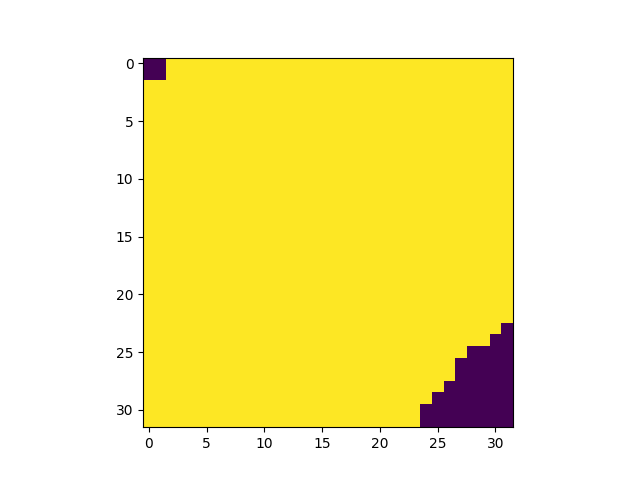

In [30]:
small_img = X_test[i]
small_pred = unet.predict(np.reshape(small_img, (1, *small_img.shape)))

plt.figure()
plt.imshow(np.squeeze(small_pred))

<IPython.core.display.Javascript object>


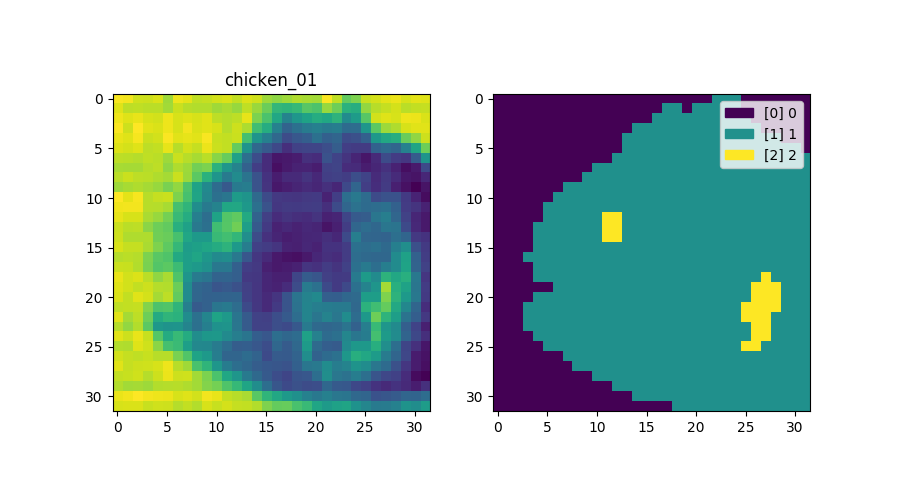

<IPython.core.display.Javascript object>


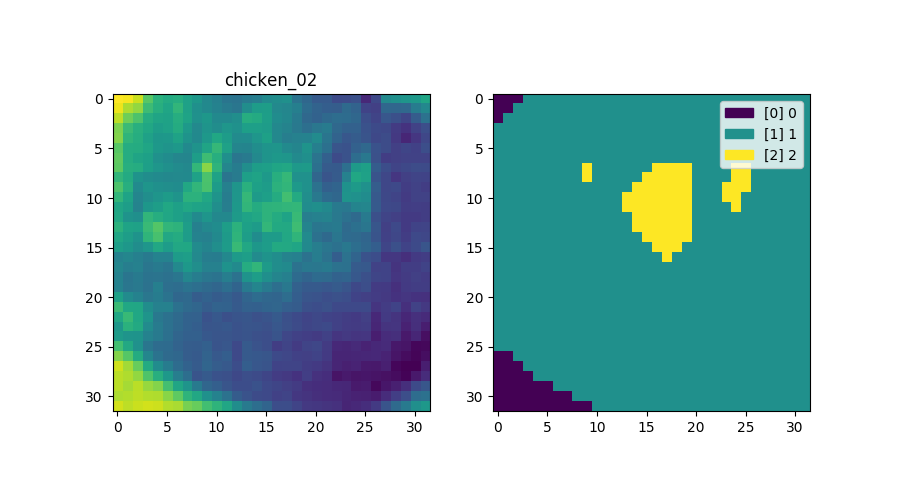

<IPython.core.display.Javascript object>


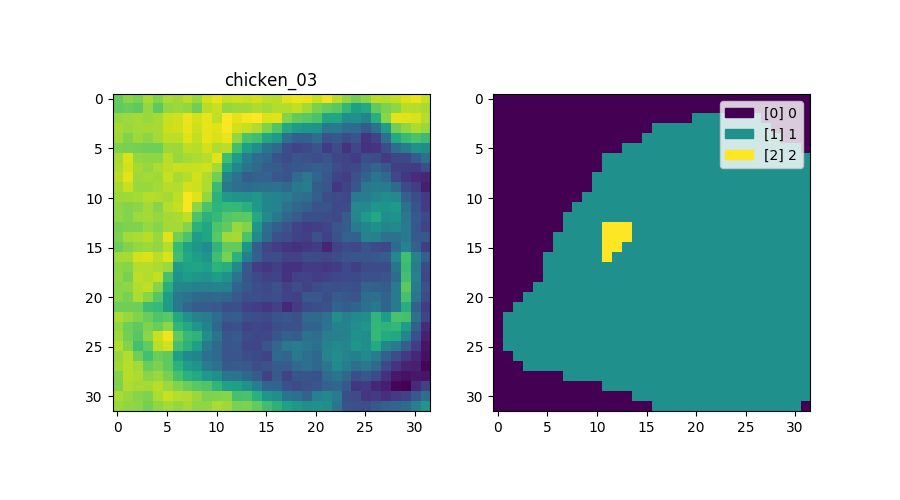

<IPython.core.display.Javascript object>


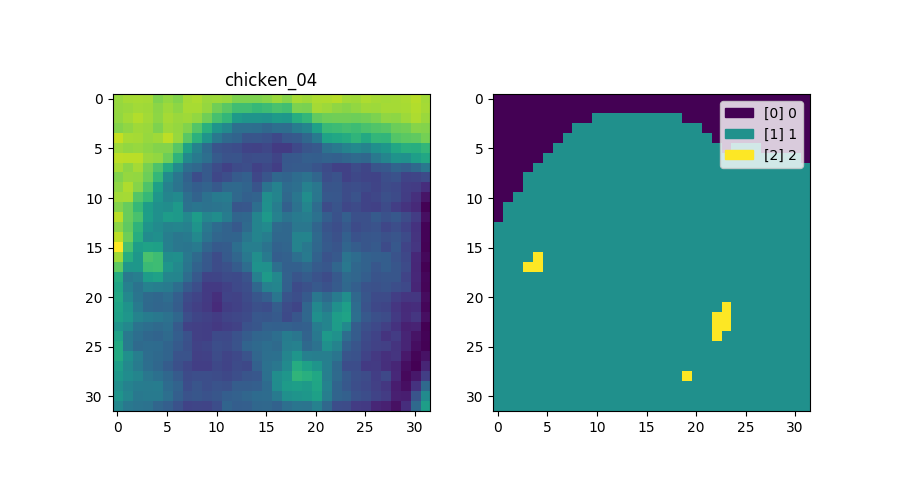

<IPython.core.display.Javascript object>


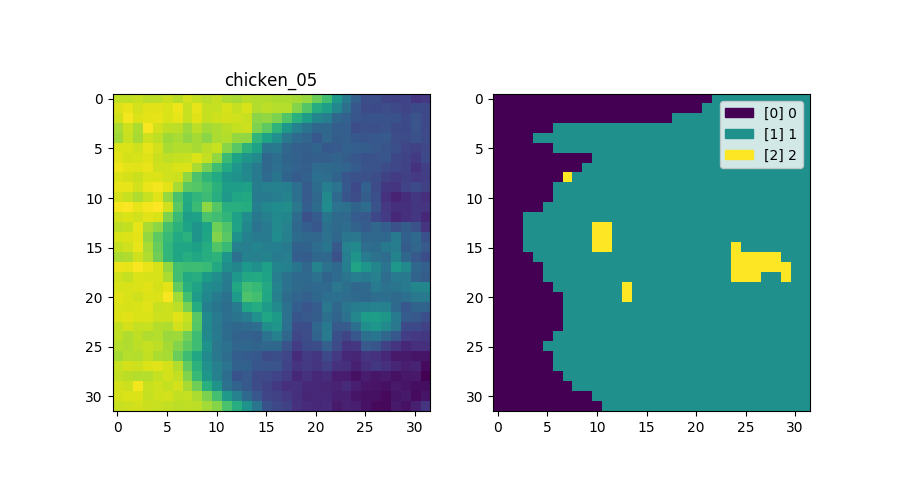

<IPython.core.display.Javascript object>


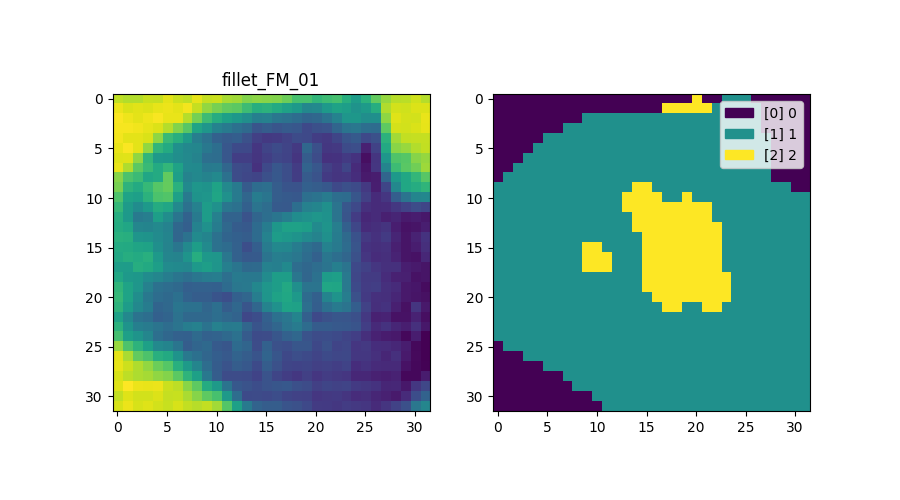

<IPython.core.display.Javascript object>


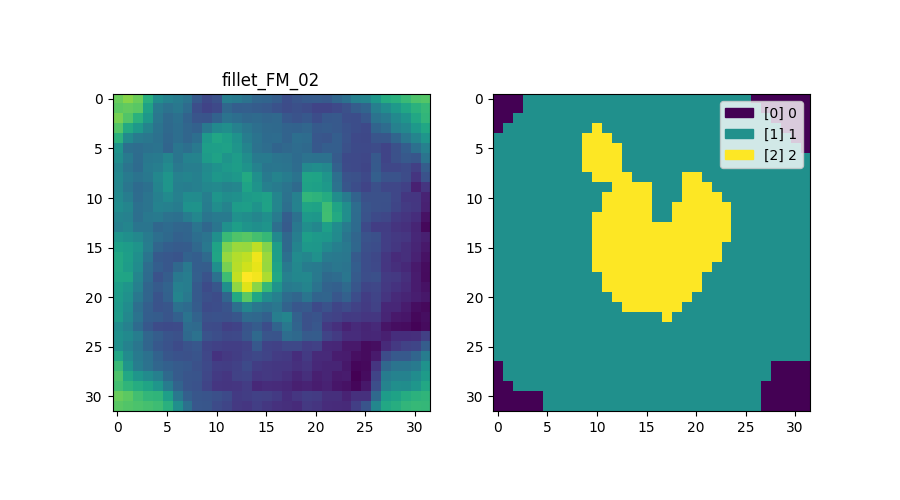

<IPython.core.display.Javascript object>


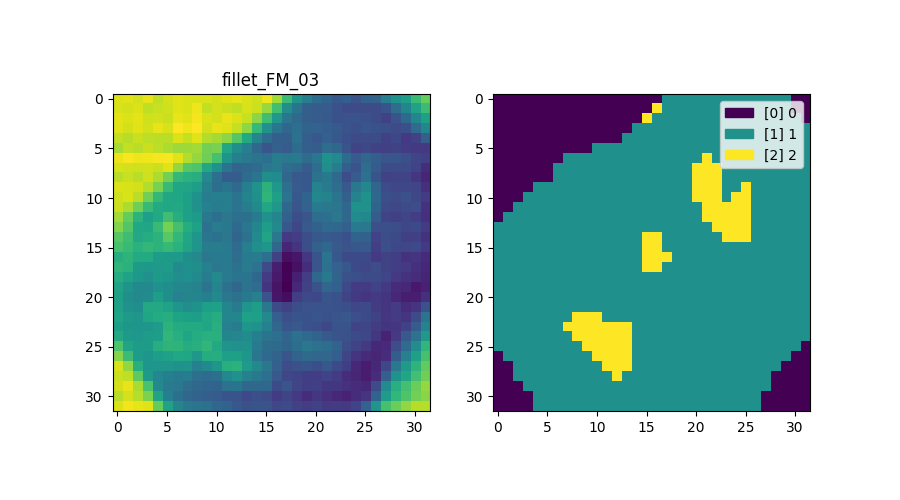

<IPython.core.display.Javascript object>


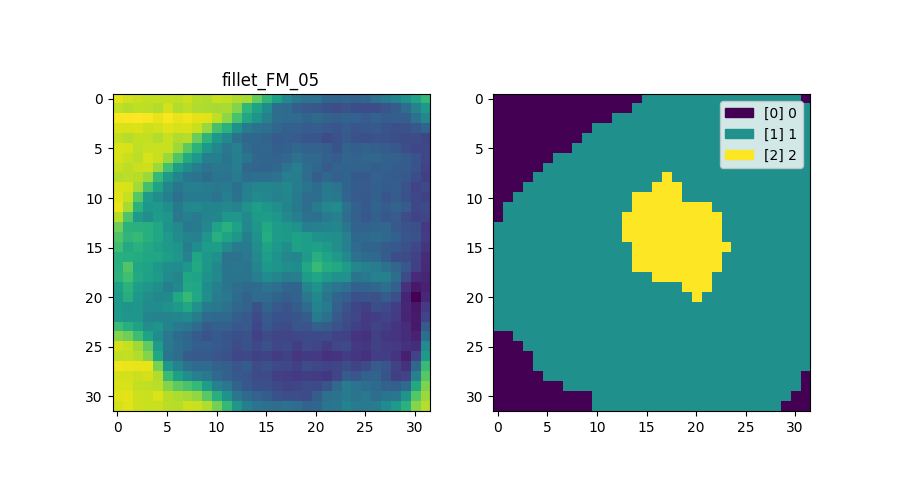

<IPython.core.display.Javascript object>


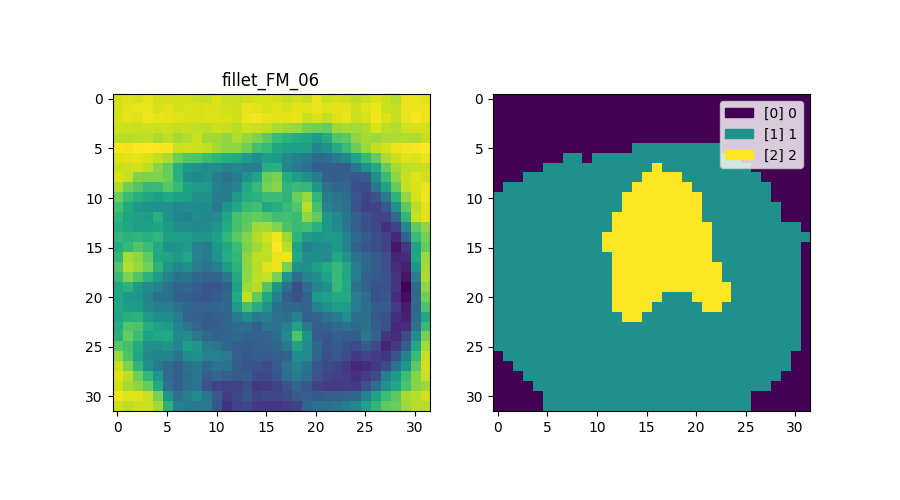

<IPython.core.display.Javascript object>


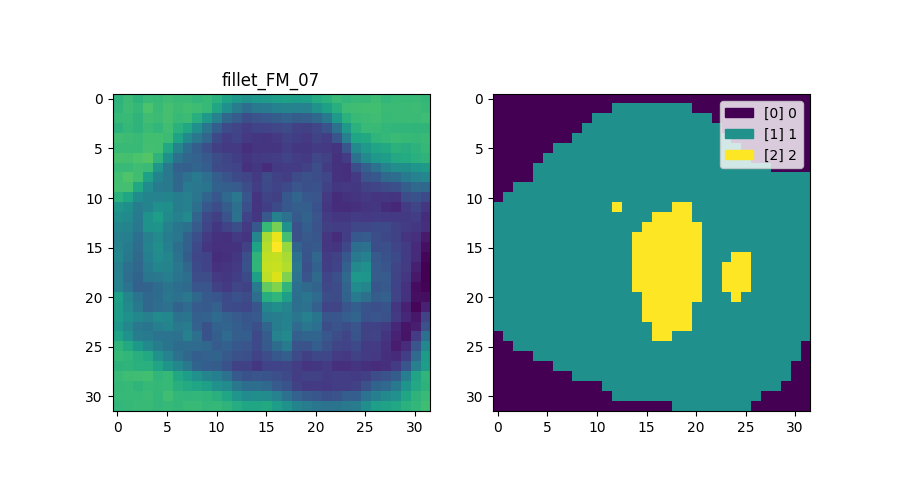

<IPython.core.display.Javascript object>


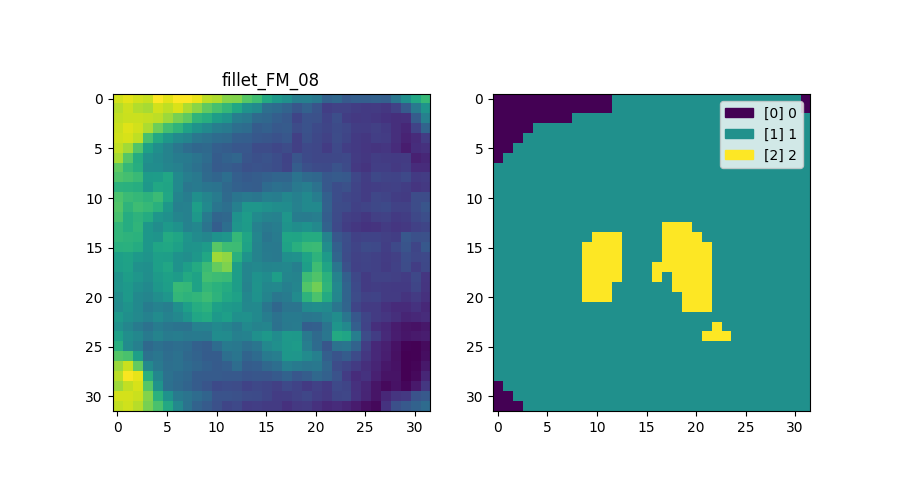

<IPython.core.display.Javascript object>


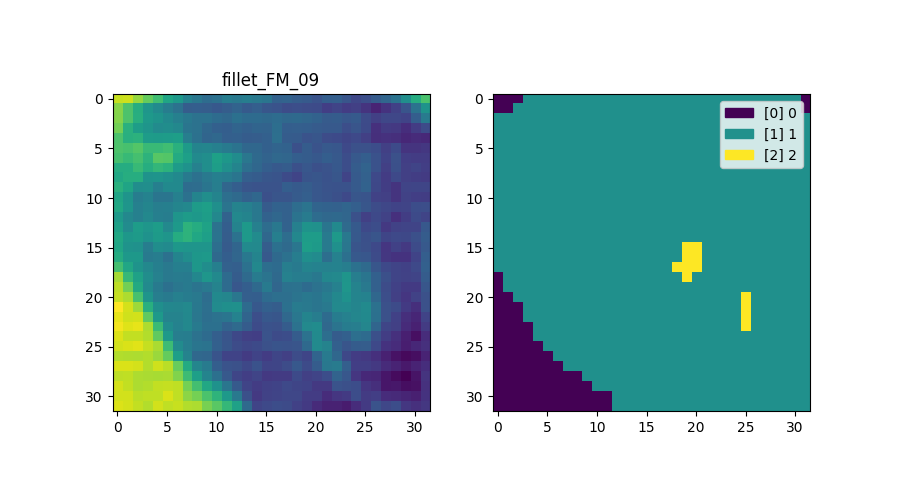

<IPython.core.display.Javascript object>


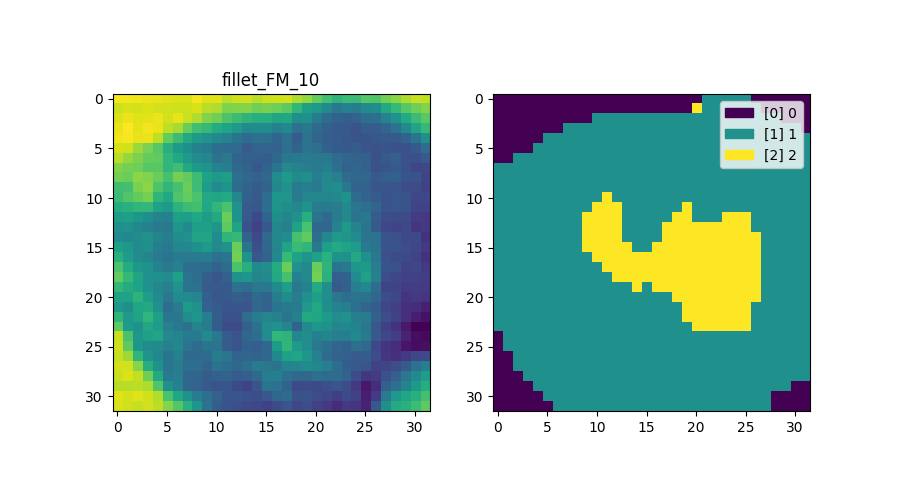

<IPython.core.display.Javascript object>


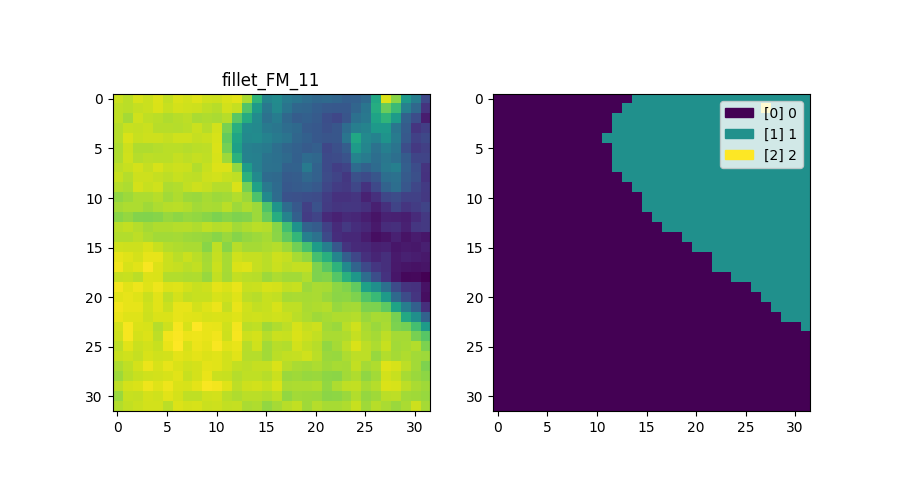

<IPython.core.display.Javascript object>


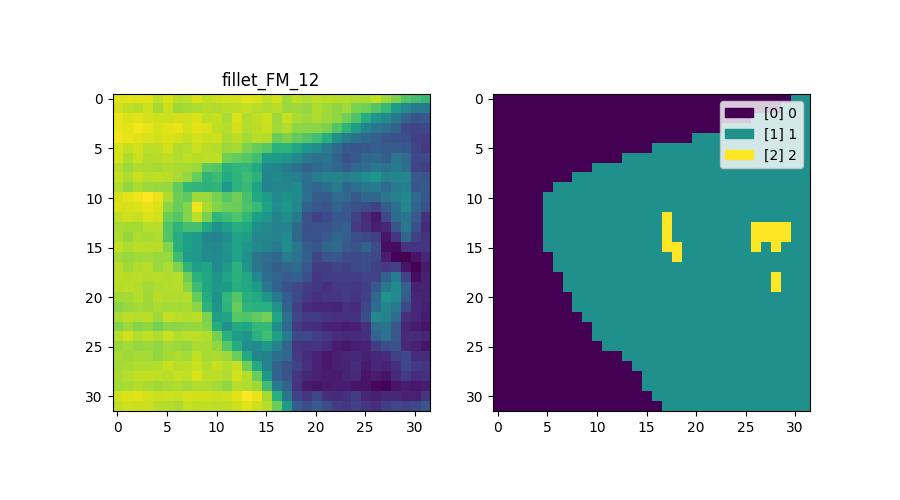

<IPython.core.display.Javascript object>


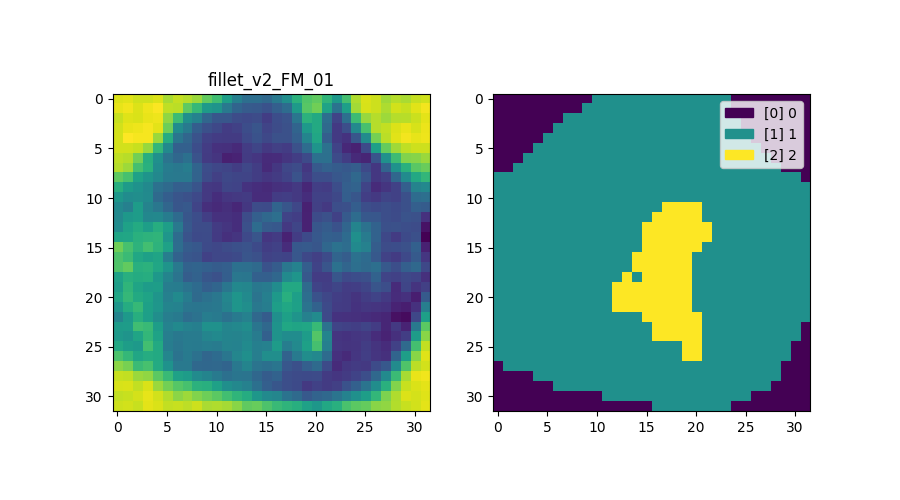

<IPython.core.display.Javascript object>


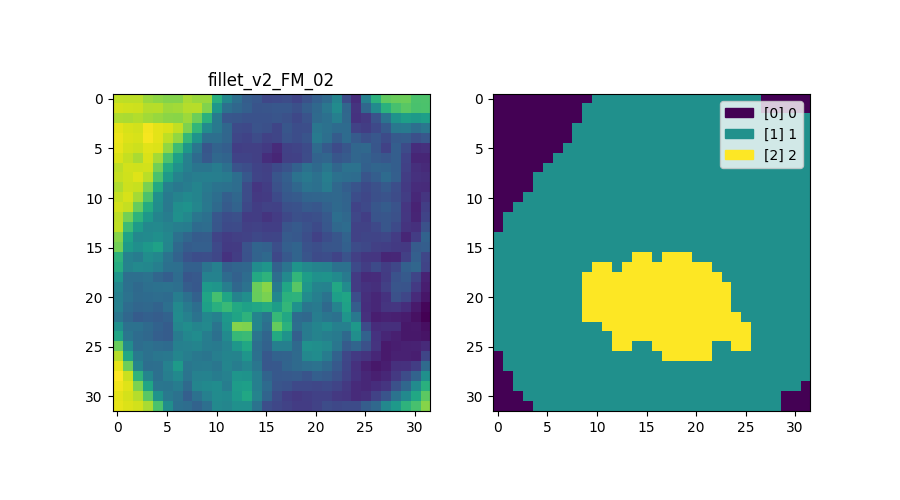

<IPython.core.display.Javascript object>


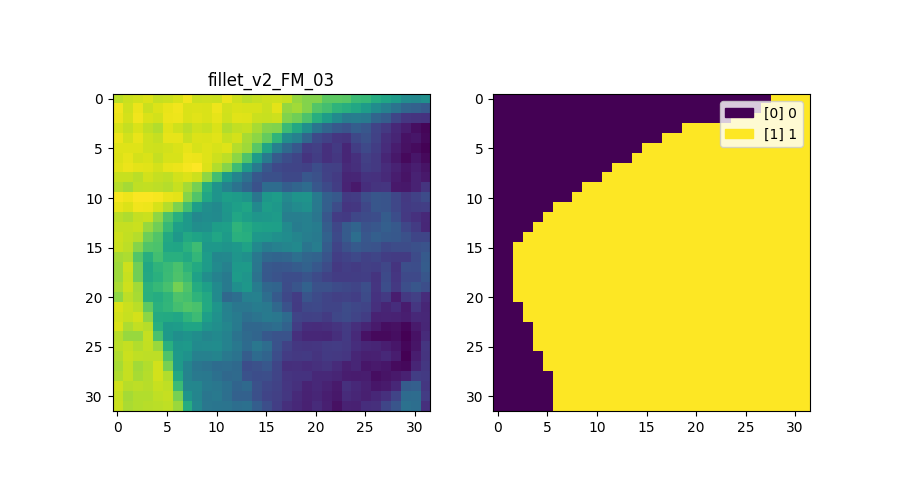

<IPython.core.display.Javascript object>


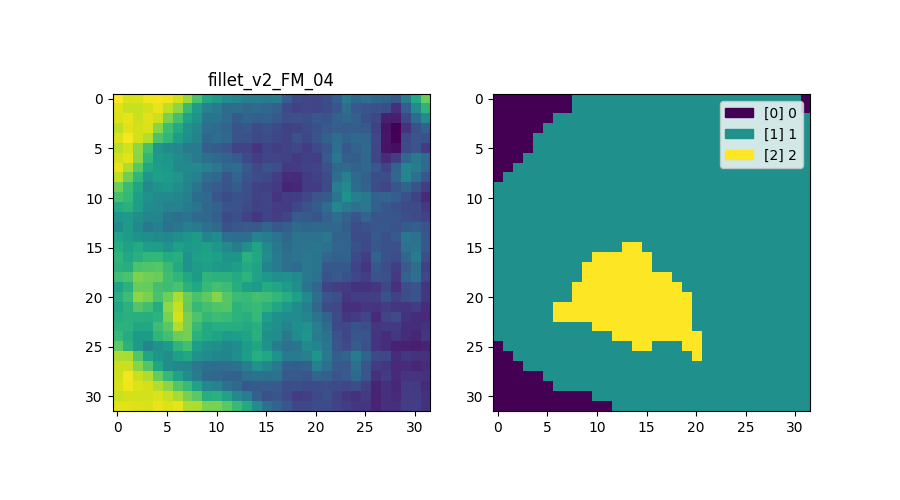

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



<IPython.core.display.Javascript object>


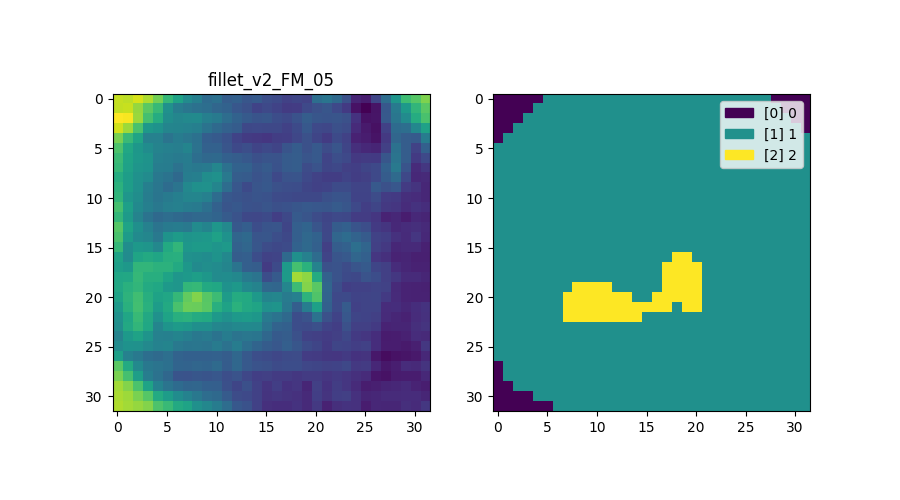

<IPython.core.display.Javascript object>


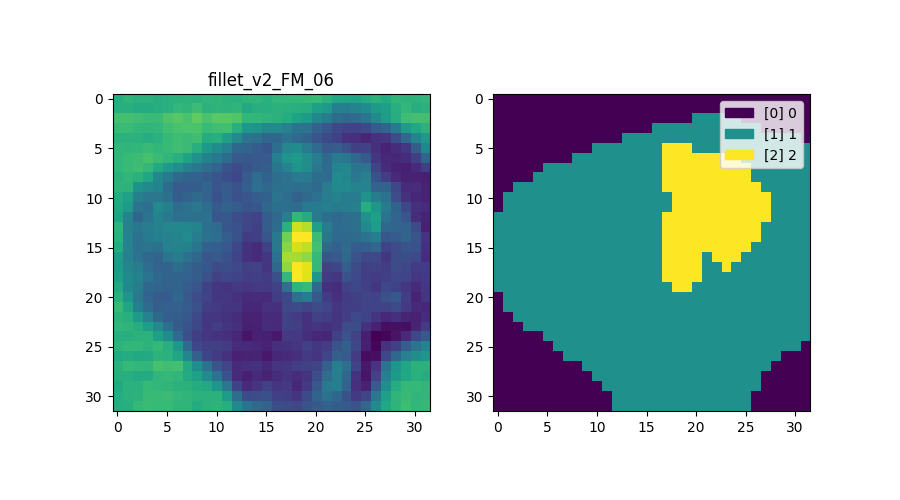

<IPython.core.display.Javascript object>


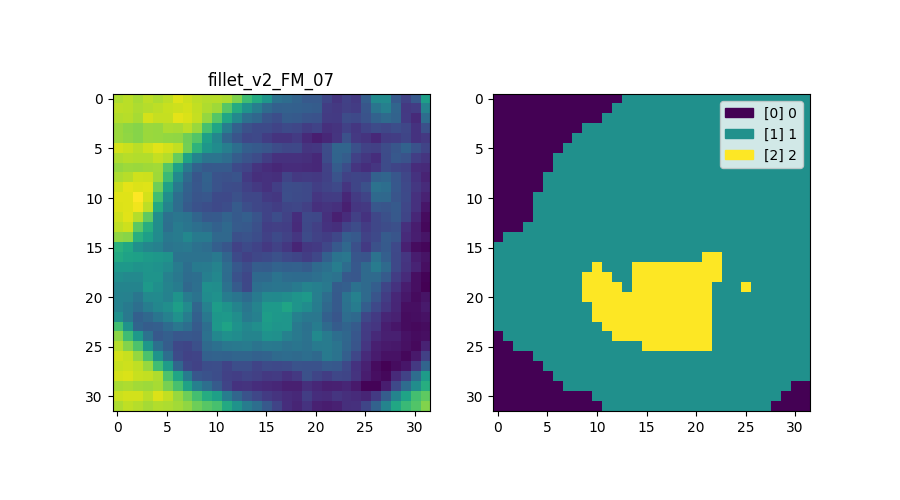

<IPython.core.display.Javascript object>


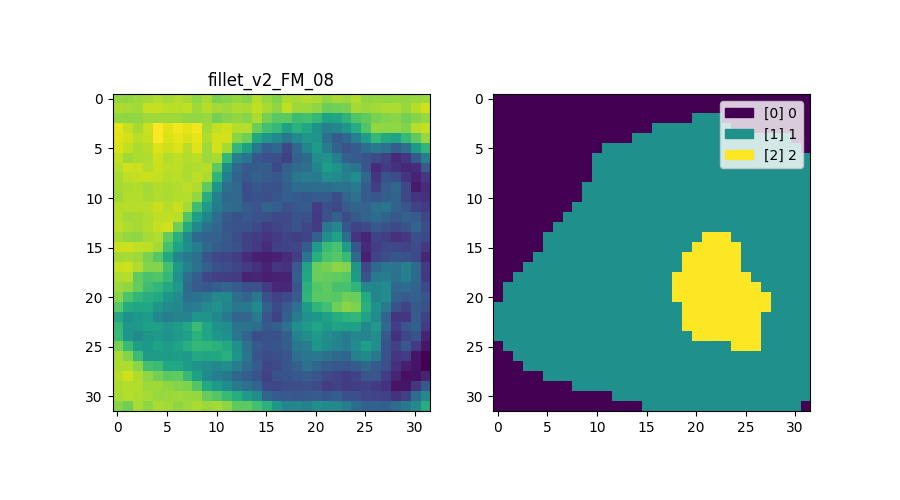

<IPython.core.display.Javascript object>


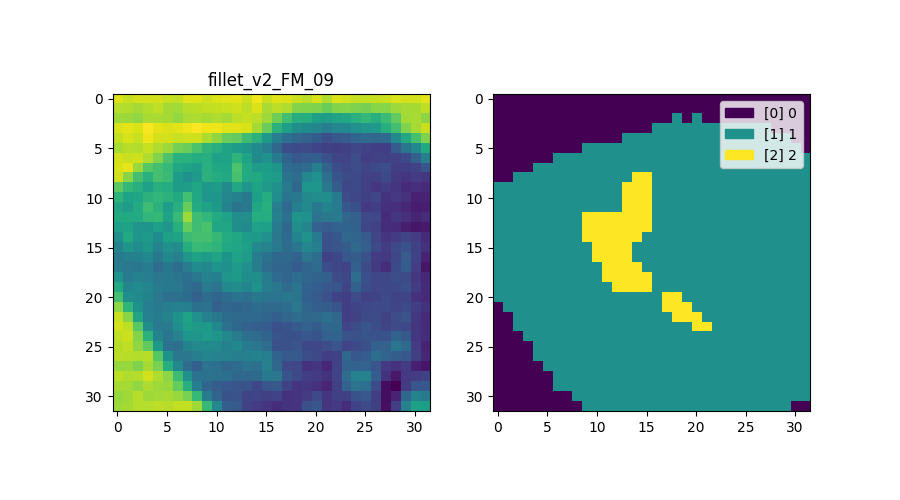

<IPython.core.display.Javascript object>


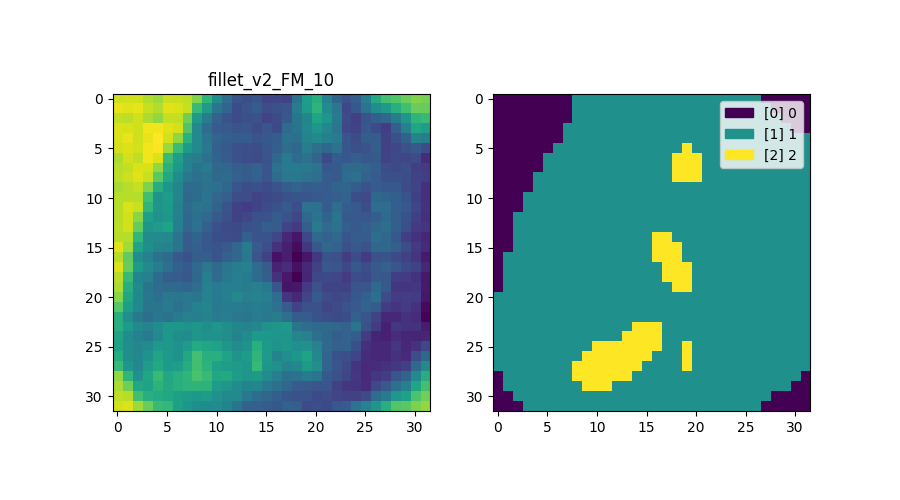

<IPython.core.display.Javascript object>


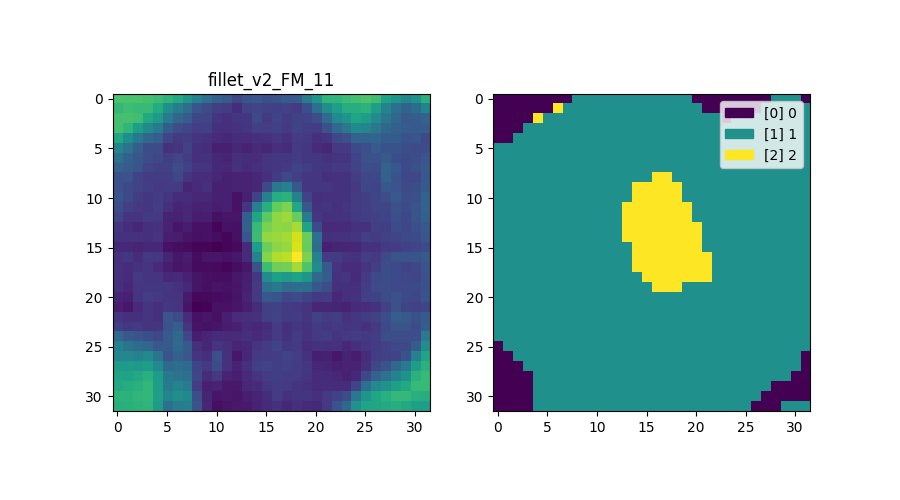

<IPython.core.display.Javascript object>


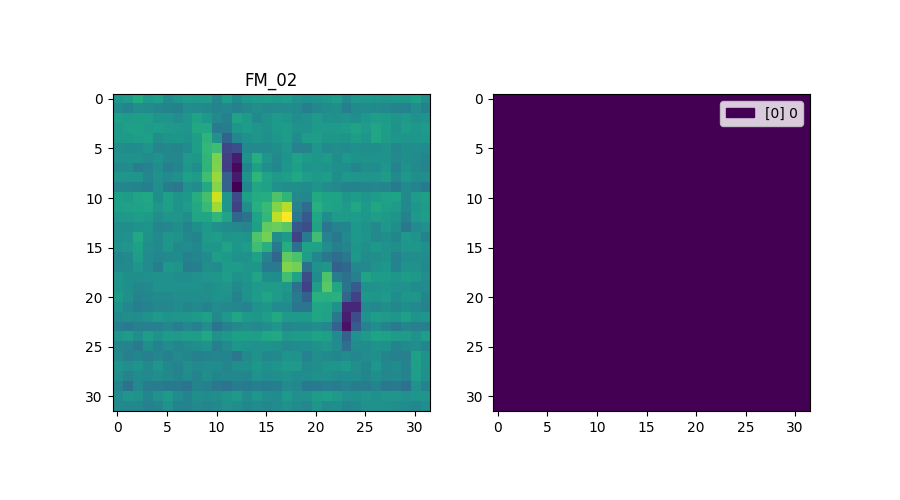

<IPython.core.display.Javascript object>


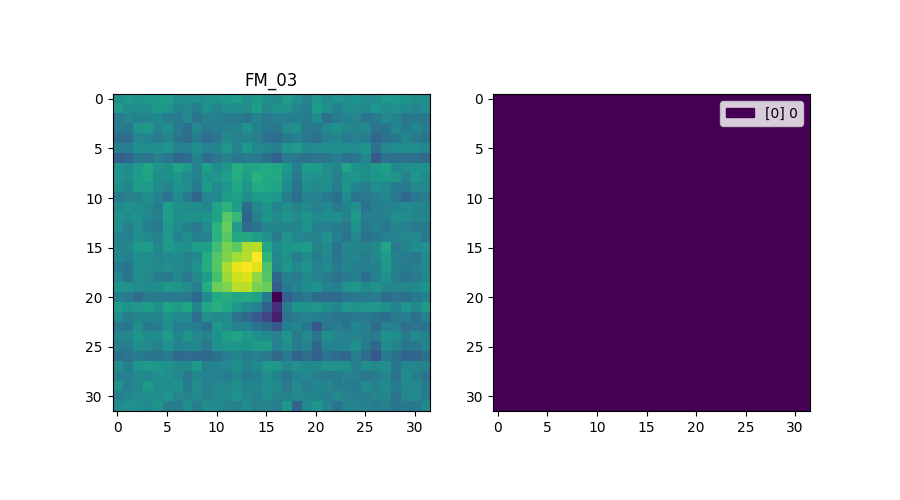

<IPython.core.display.Javascript object>


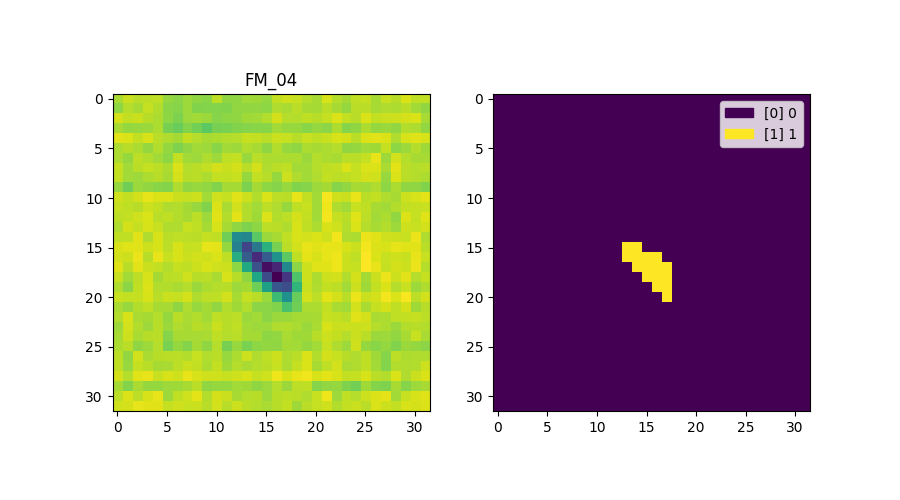

<IPython.core.display.Javascript object>


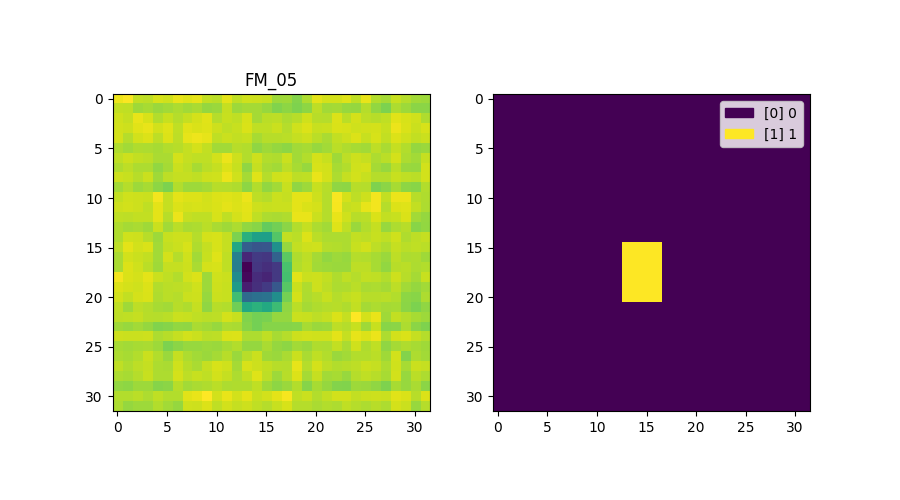

<IPython.core.display.Javascript object>


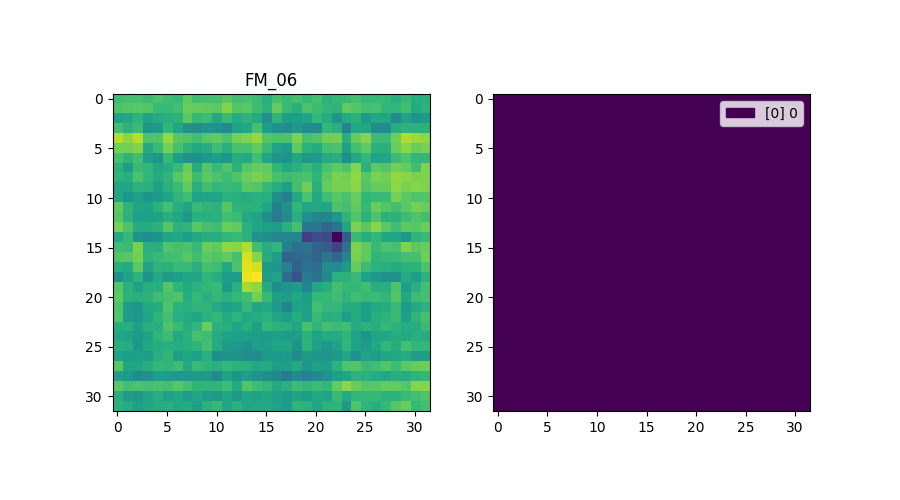

<IPython.core.display.Javascript object>


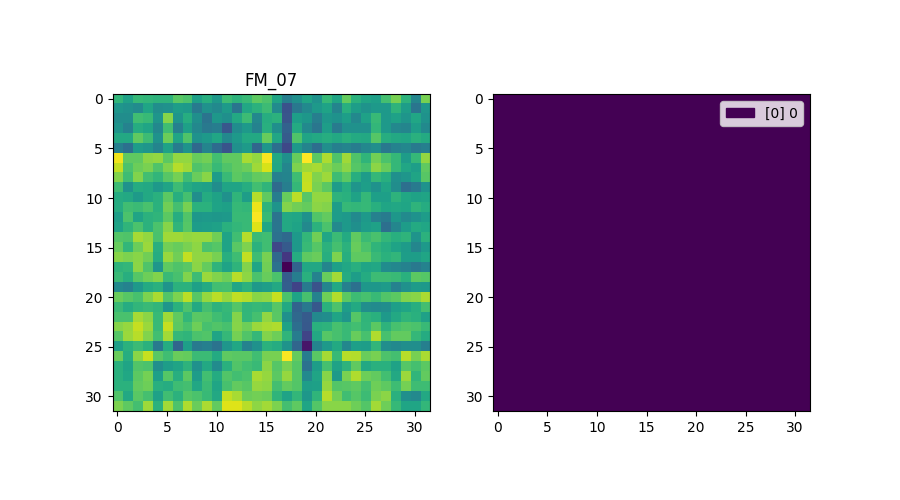

<IPython.core.display.Javascript object>


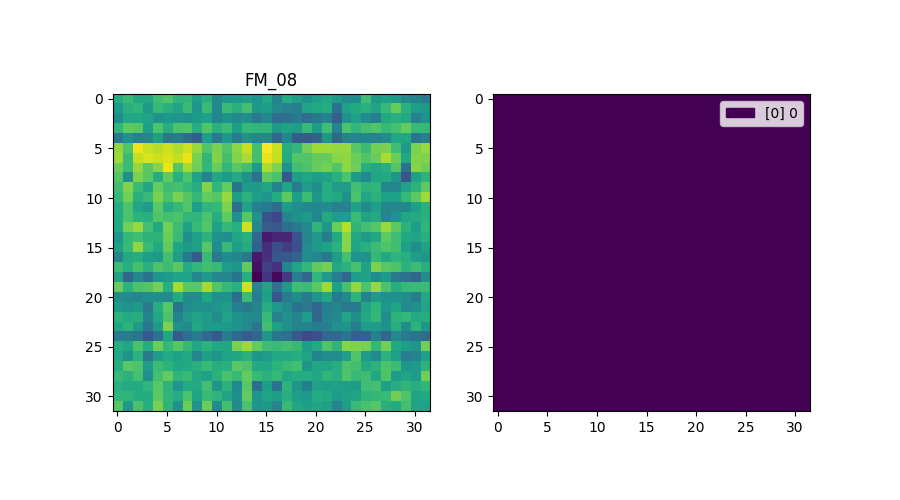

<IPython.core.display.Javascript object>


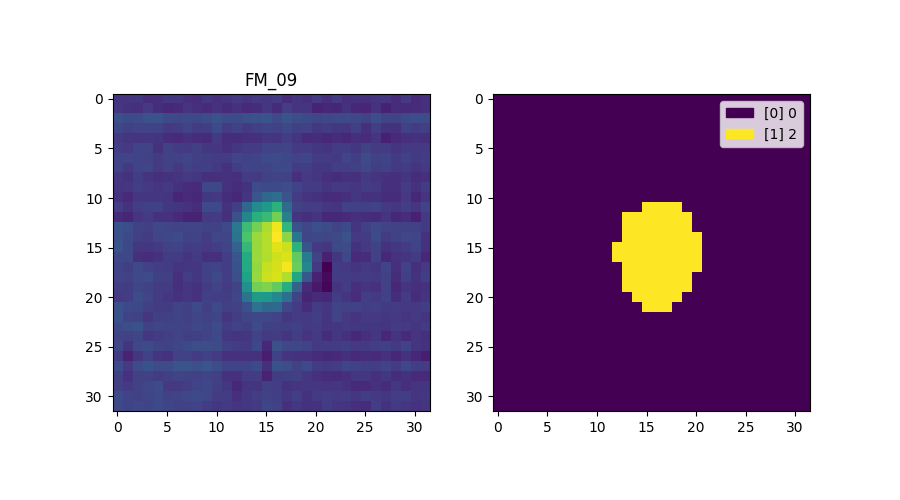

<IPython.core.display.Javascript object>


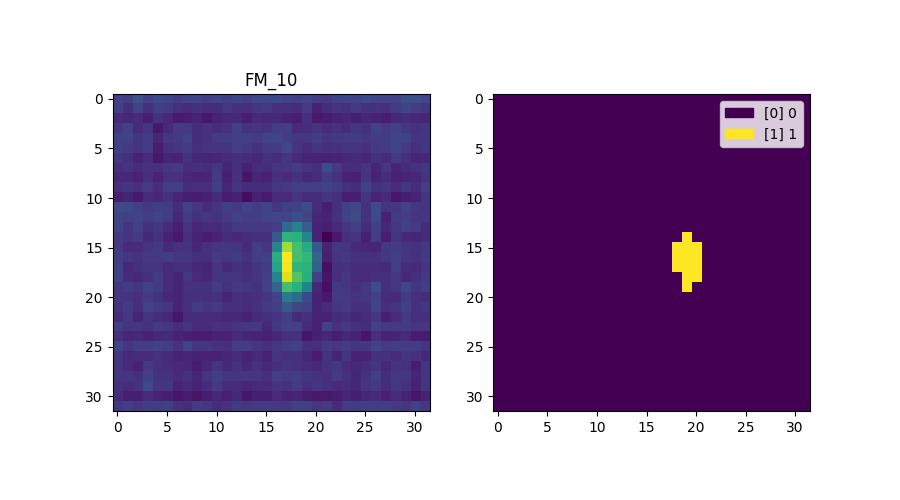

<IPython.core.display.Javascript object>


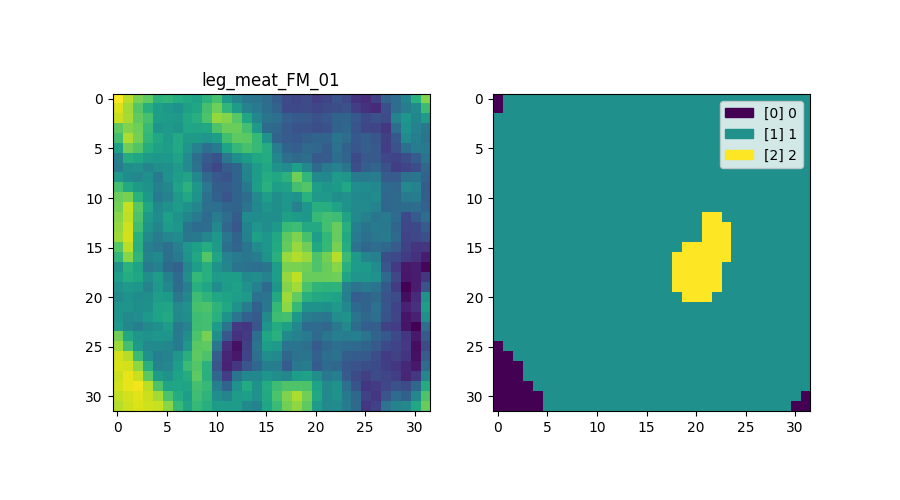

<IPython.core.display.Javascript object>


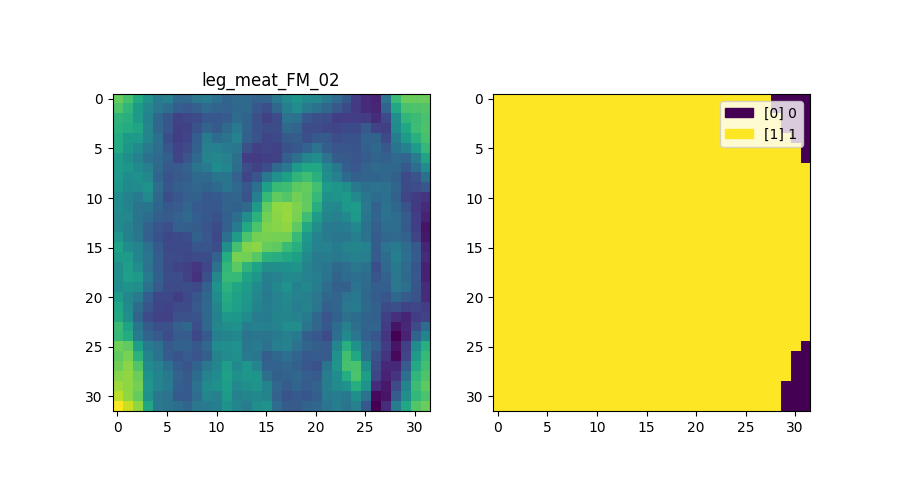

<IPython.core.display.Javascript object>


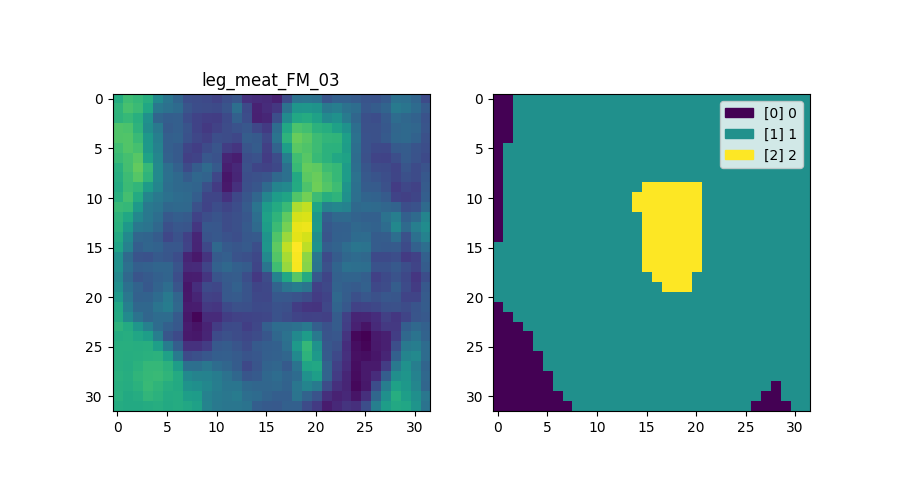

<IPython.core.display.Javascript object>


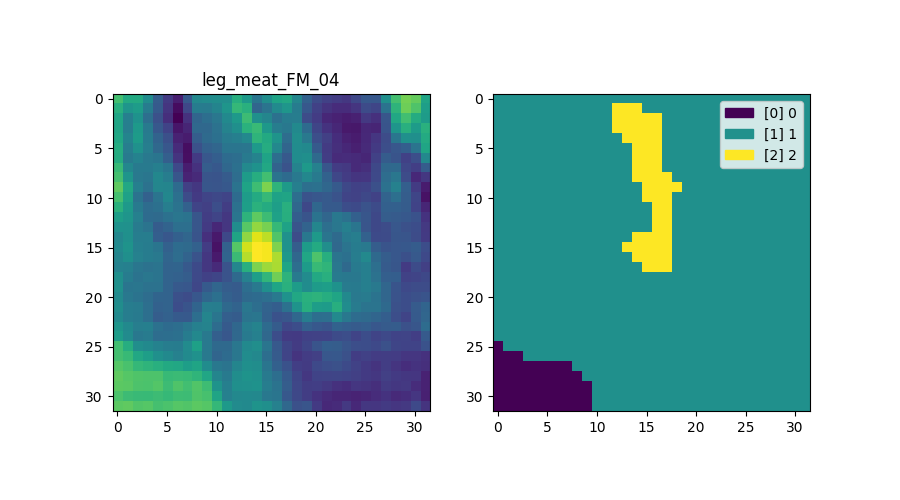

<IPython.core.display.Javascript object>


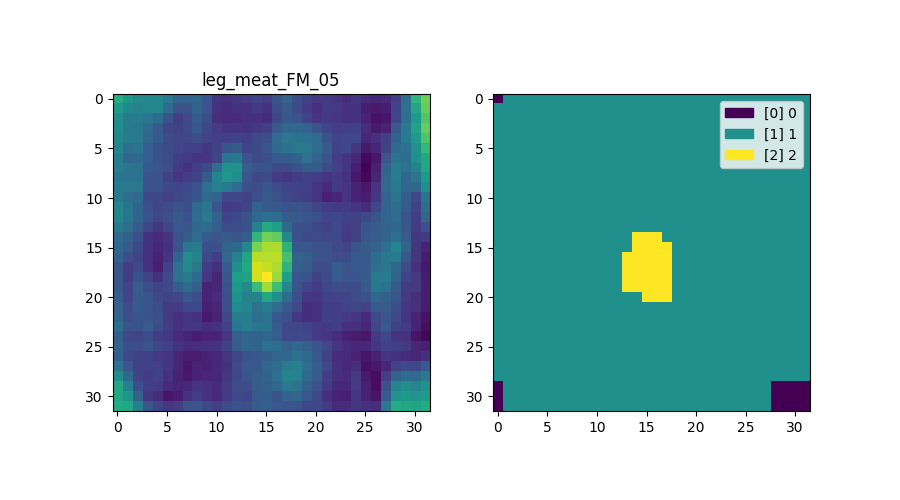

<IPython.core.display.Javascript object>


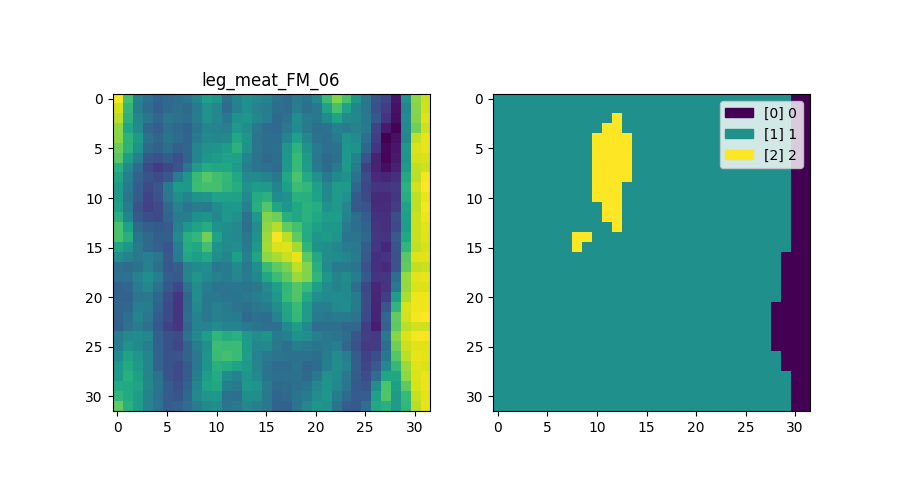

<IPython.core.display.Javascript object>


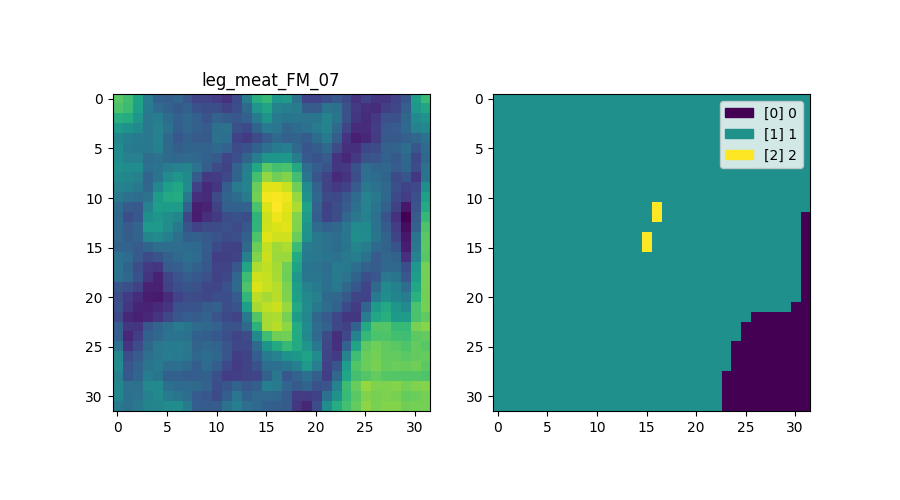

<IPython.core.display.Javascript object>


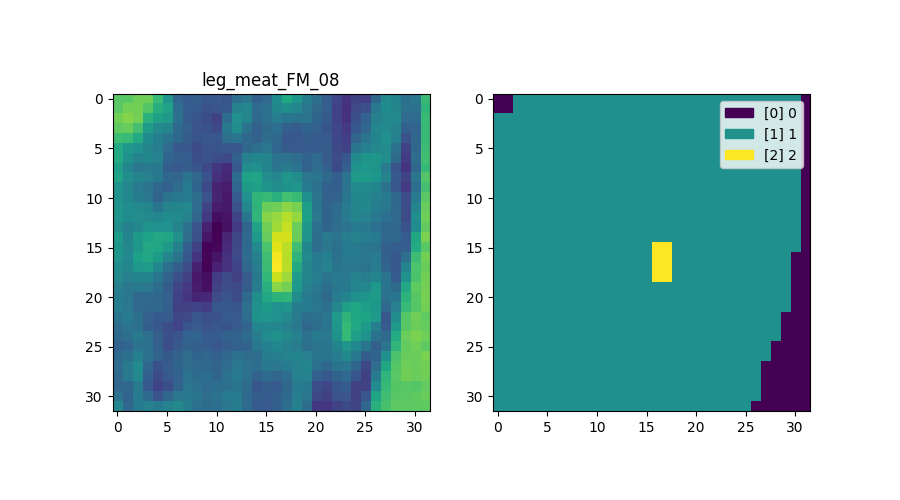

<IPython.core.display.Javascript object>


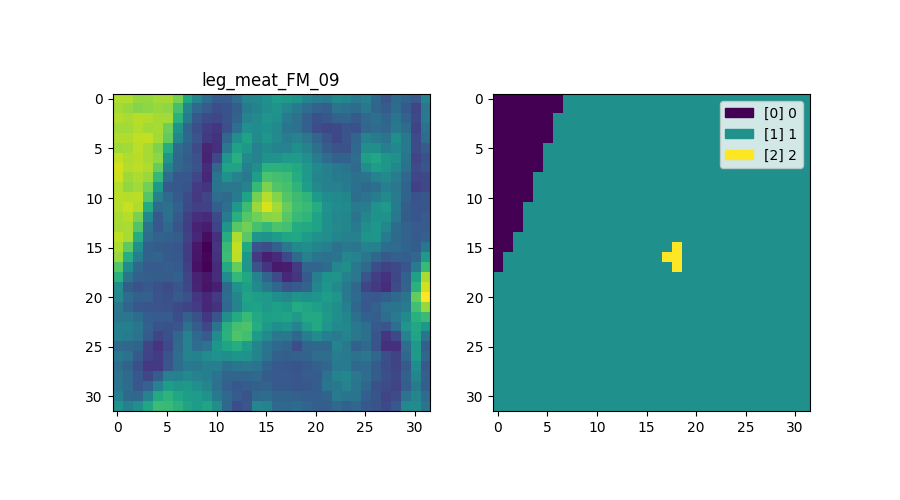

<IPython.core.display.Javascript object>


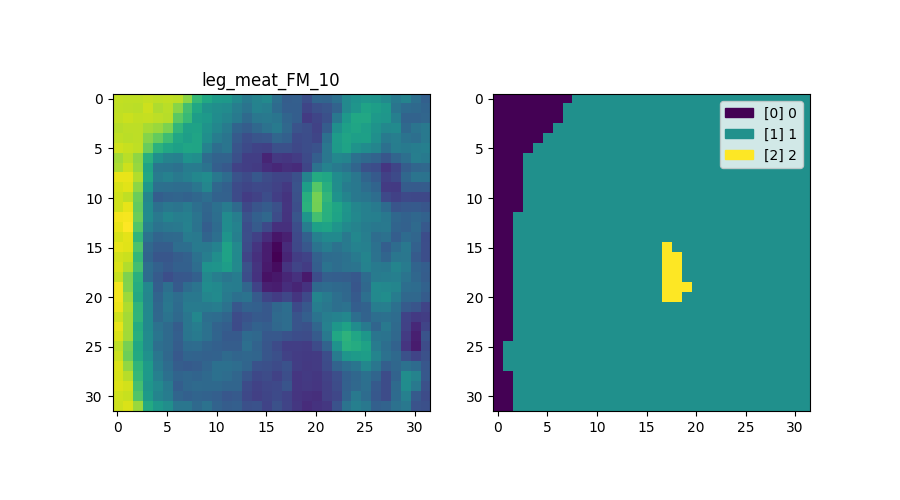

<IPython.core.display.Javascript object>


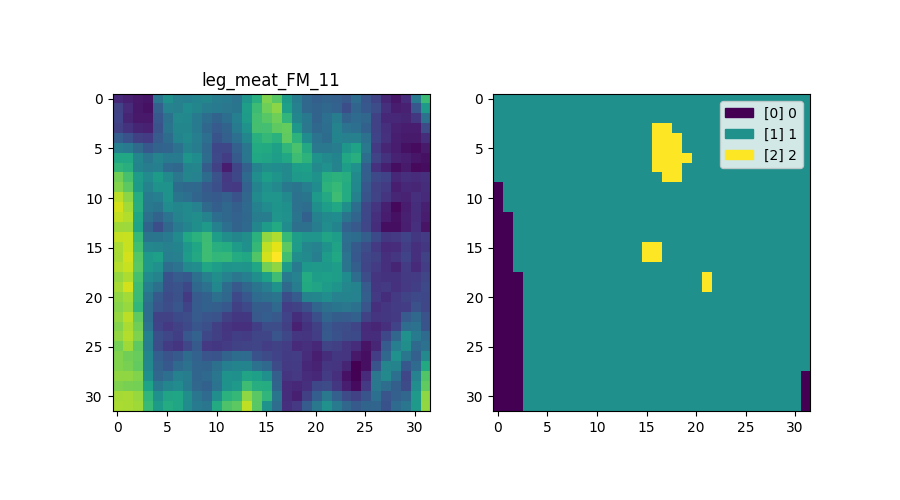

<IPython.core.display.Javascript object>


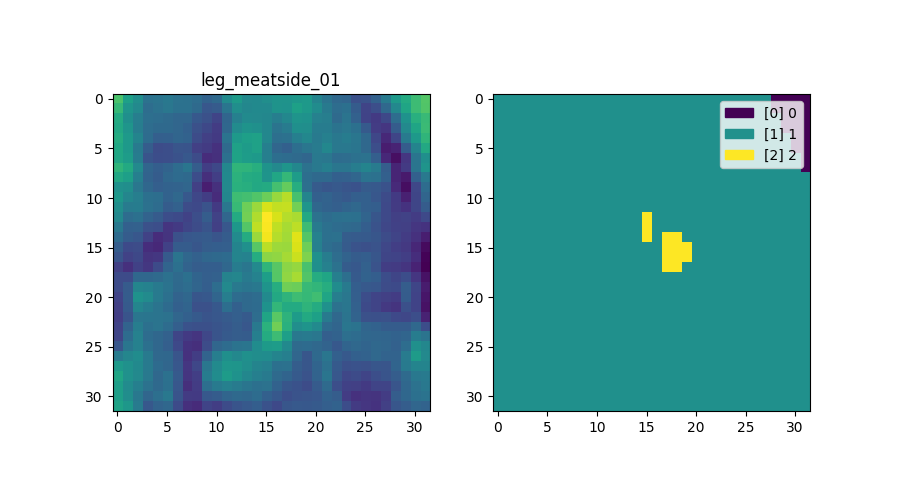

<IPython.core.display.Javascript object>


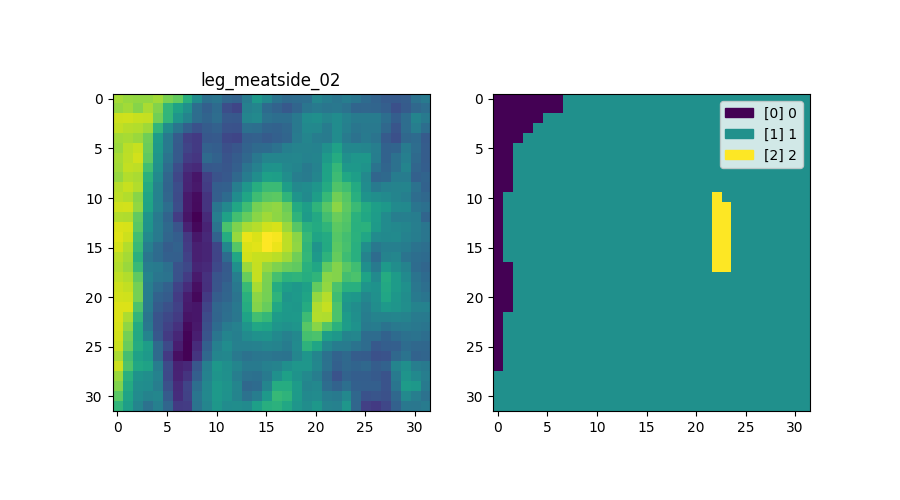

<IPython.core.display.Javascript object>


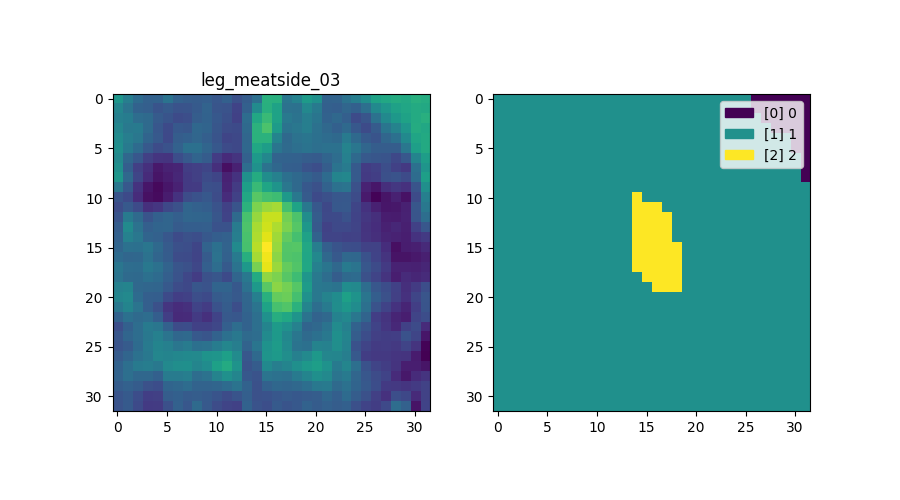

<IPython.core.display.Javascript object>


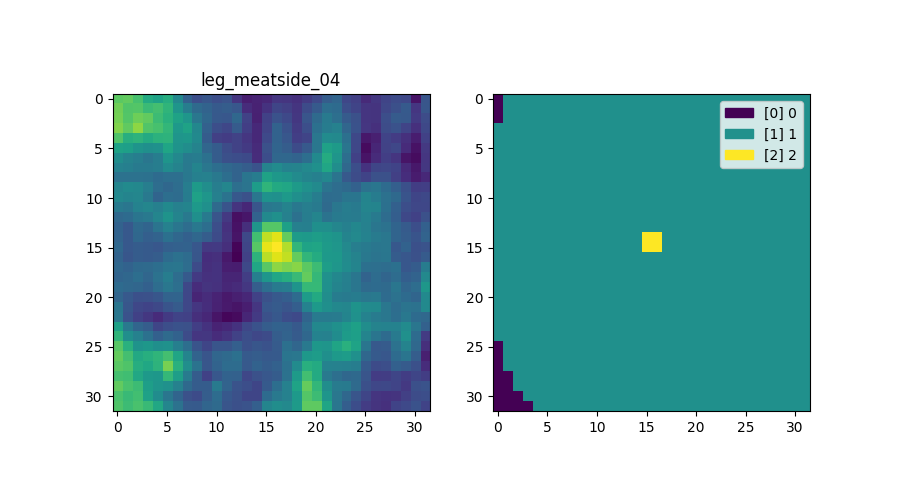

<IPython.core.display.Javascript object>


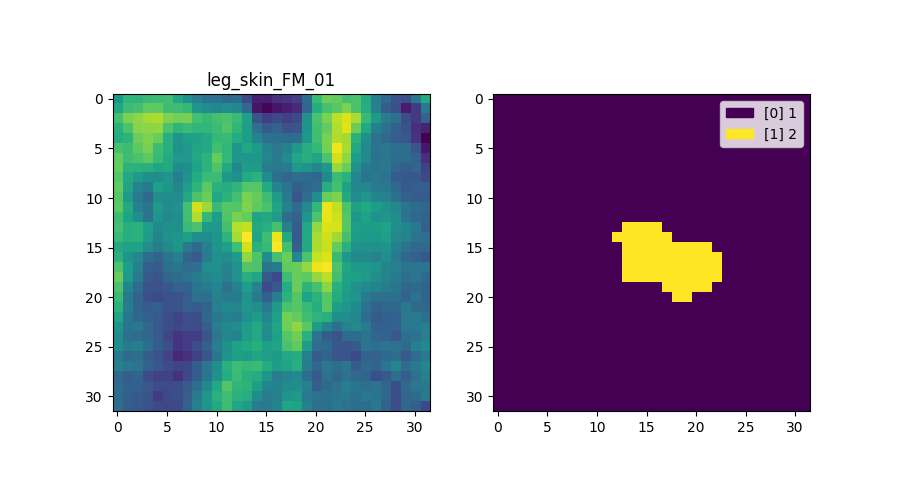

<IPython.core.display.Javascript object>


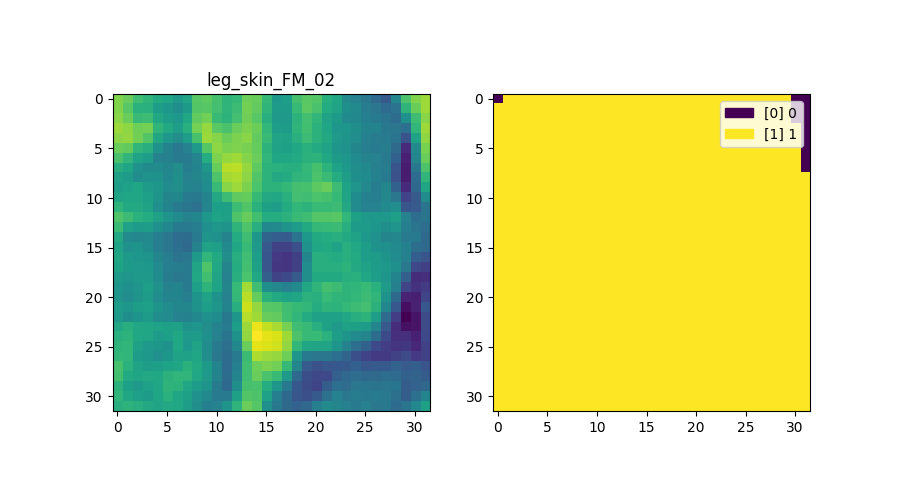

<IPython.core.display.Javascript object>


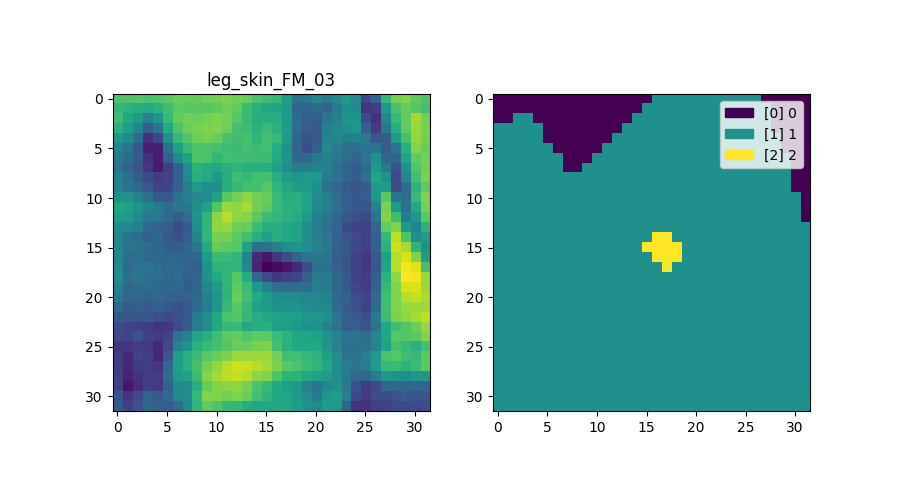

<IPython.core.display.Javascript object>


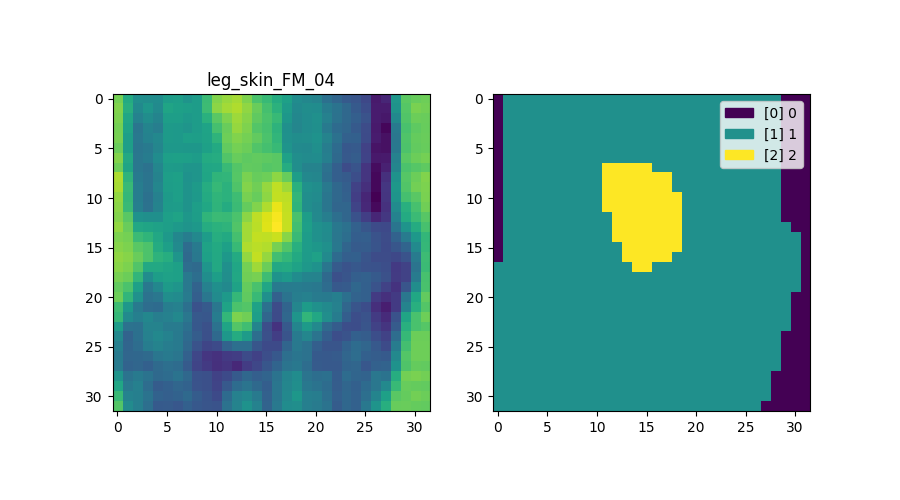

<IPython.core.display.Javascript object>


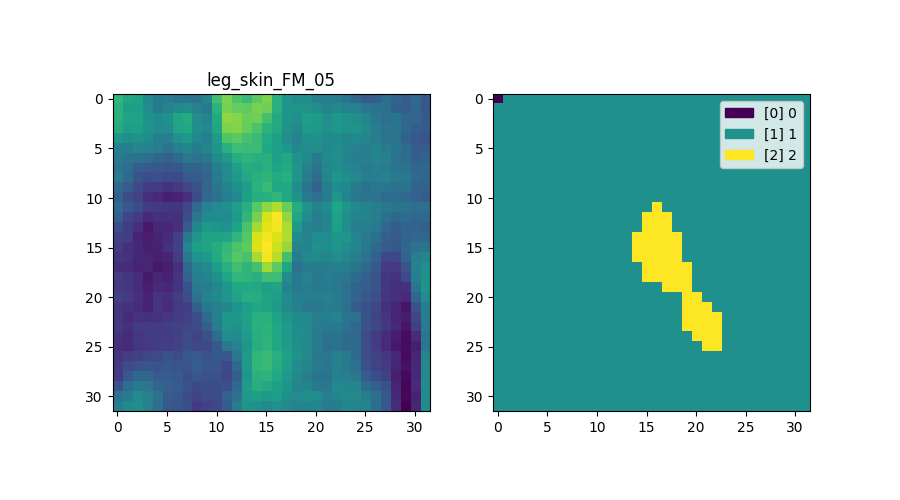

<IPython.core.display.Javascript object>


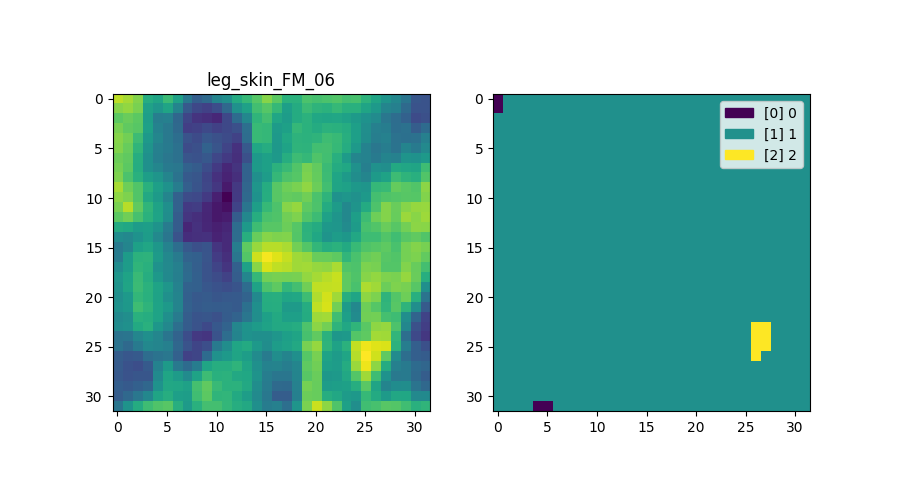

<IPython.core.display.Javascript object>


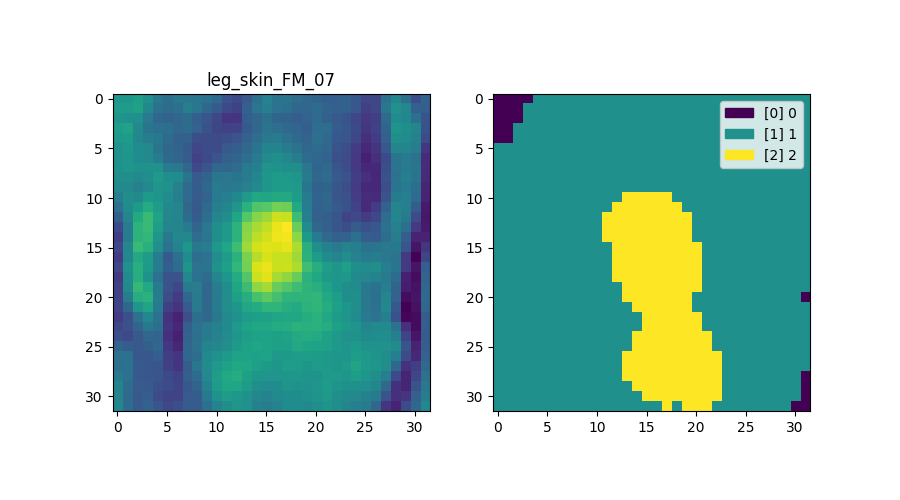

<IPython.core.display.Javascript object>


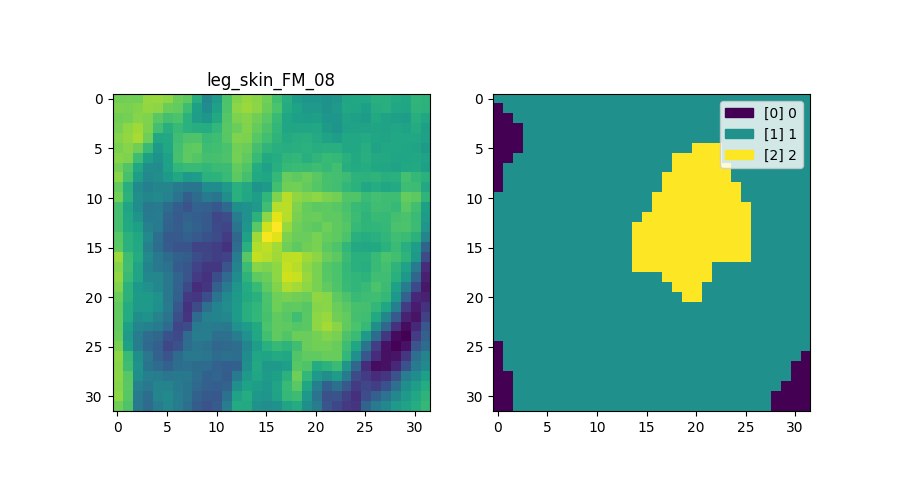

<IPython.core.display.Javascript object>


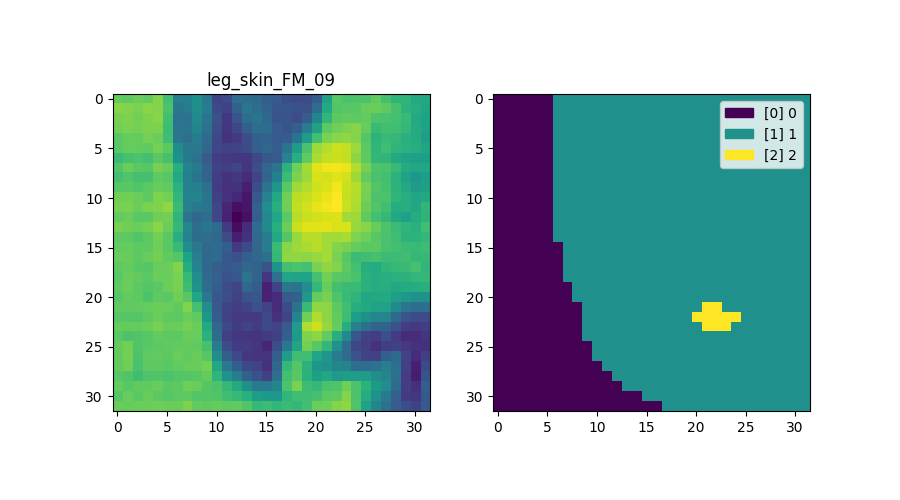

<IPython.core.display.Javascript object>


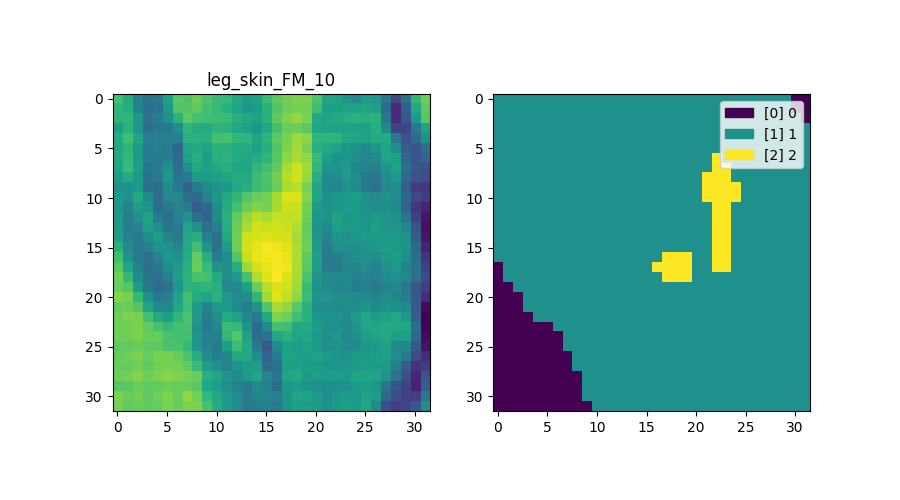

<IPython.core.display.Javascript object>


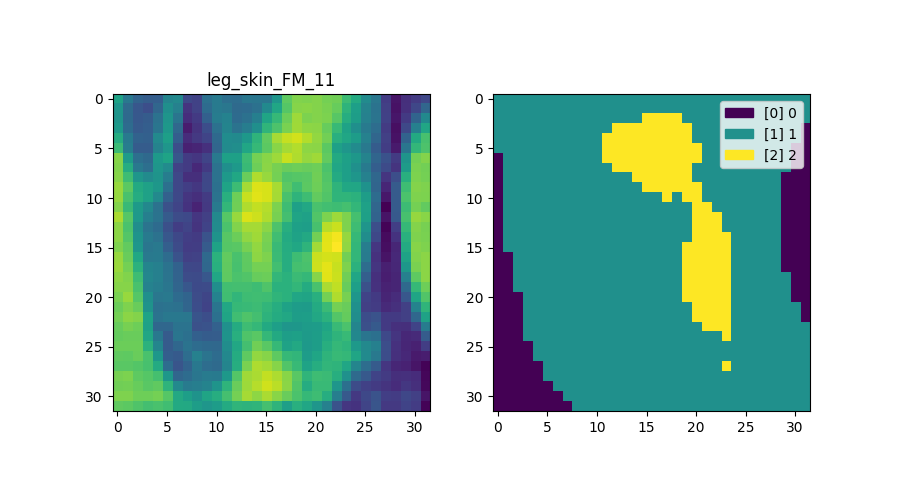

<IPython.core.display.Javascript object>


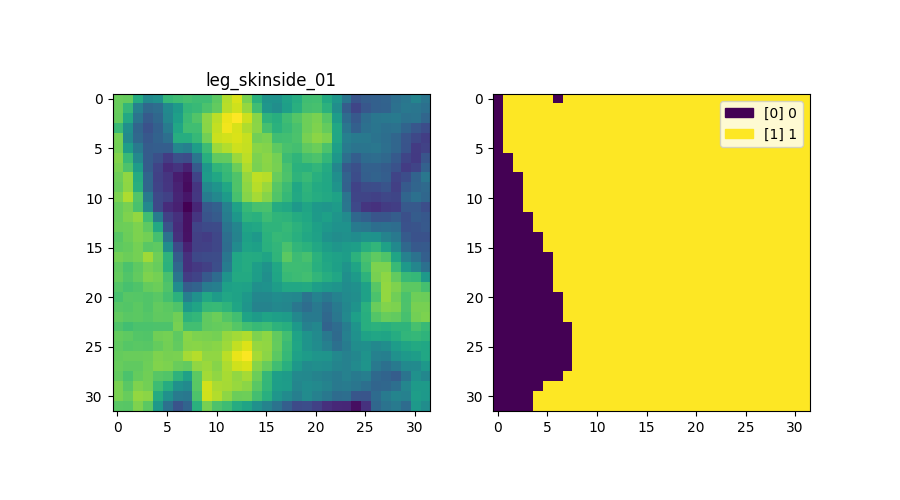

<IPython.core.display.Javascript object>


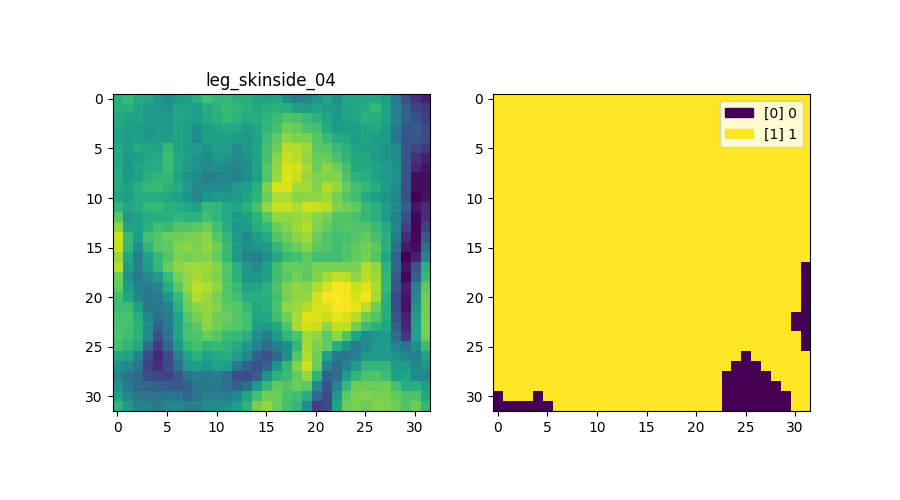

<IPython.core.display.Javascript object>


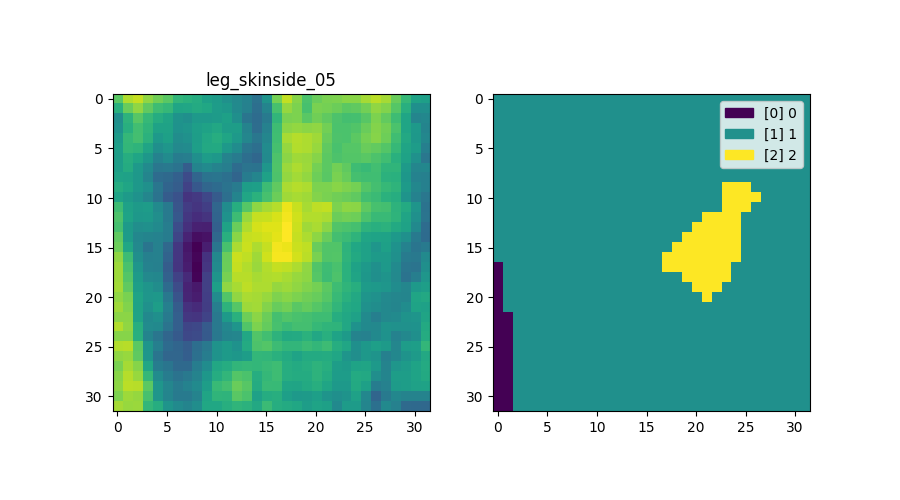

<IPython.core.display.Javascript object>


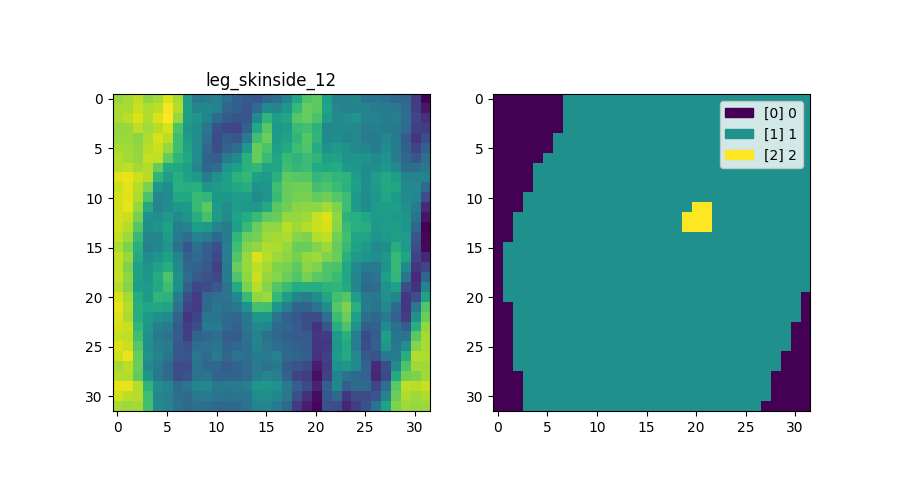

<IPython.core.display.Javascript object>


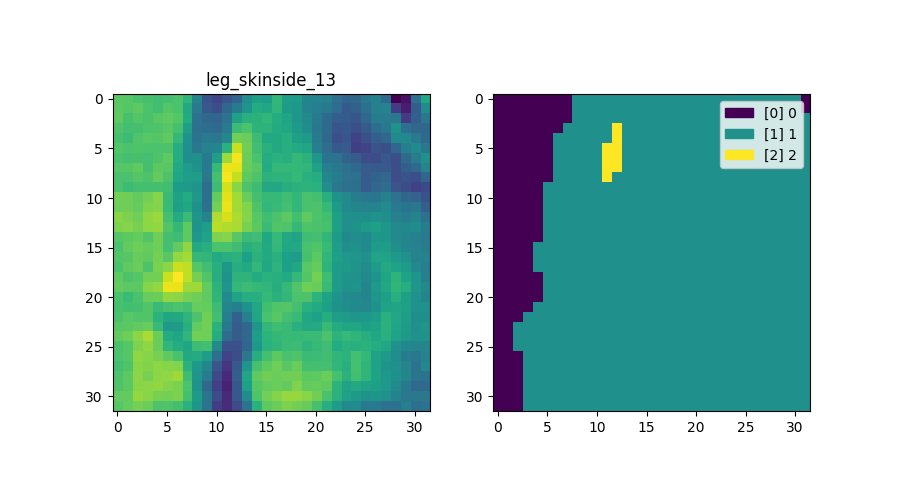

<IPython.core.display.Javascript object>


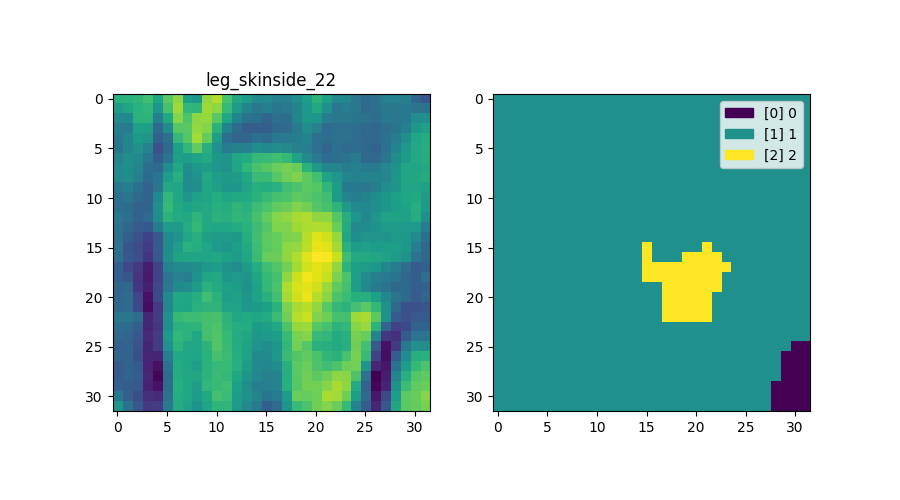

<IPython.core.display.Javascript object>


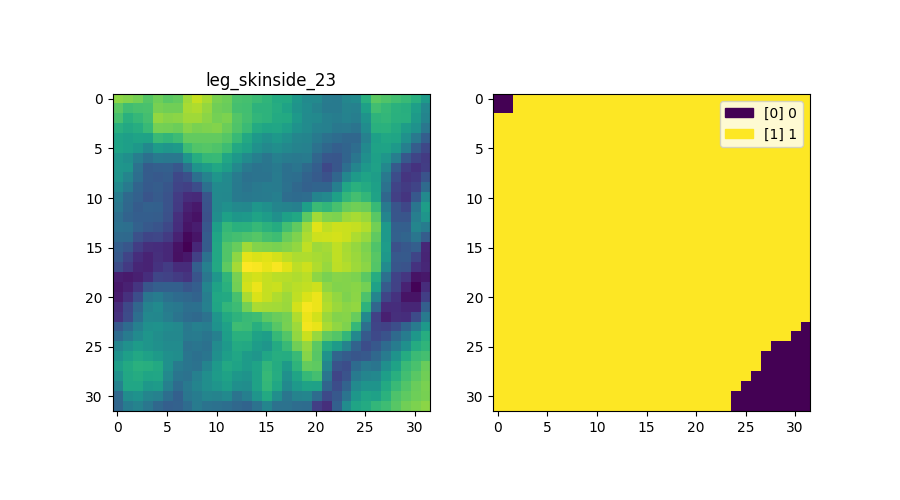

In [38]:
# Interactive plots
%matplotlib notebook

for i in range(len(X_test)):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title(file_list[i])
    plt.imshow(X_test[i, :, :, 7])
    
    plt.subplot(122)
    y_pred = unet.predict(np.reshape(X_test[i], (1, *X_test[i].shape)))
    img = plt.imshow(np.squeeze(y_pred))
    mypackage.Dataset._Dataset__add_legend_to_image(y_pred, img)

## Other test stuff

In [2]:
# Load the real dataset
X, Y, info = mypackage.Dataset.load("data/tomra", only_with_contaminant=False)

enlarged_X, enlarged_Y = mypackage.Dataset.make_zoomed_in_dataset(X, Y, size=32, sample_multiplication=7, contaminant_type=3)

X_train, X_test, Y_train, Y_test = mypackage.Dataset.train_test_split(enlarged_X, enlarged_Y, testRatio=0.3)

X_test, X_train, scaler = mypackage.Dataset.scale(X_test, X_train, scaler='GlobalStandardization')

print(np.unique(Y_test), Y_test.shape, (X_test.min(), X_test.max()), X_test.shape, X_train.shape)

[1. 2. 3.] (72, 32, 32, 1) (-3.3798091427302, 6.771767412135991) (72, 32, 32, 208) (166, 32, 32, 208)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



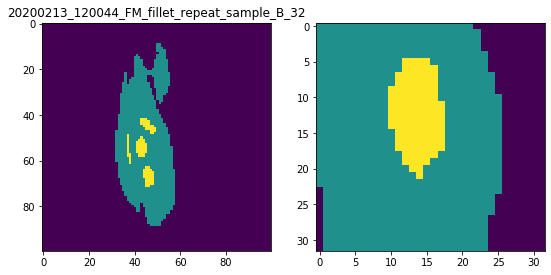

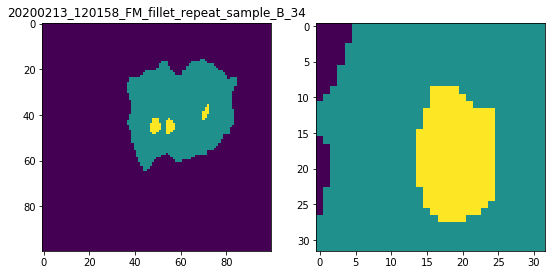

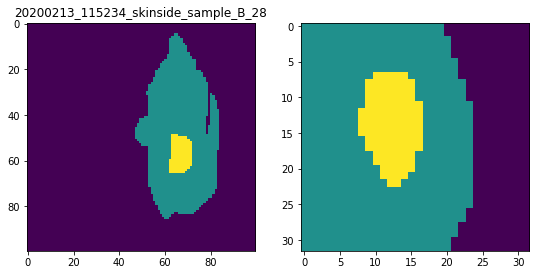

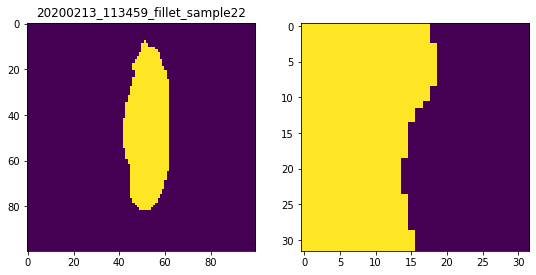

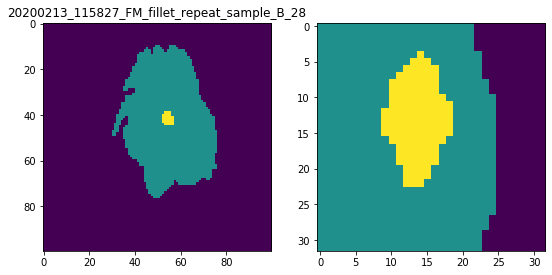

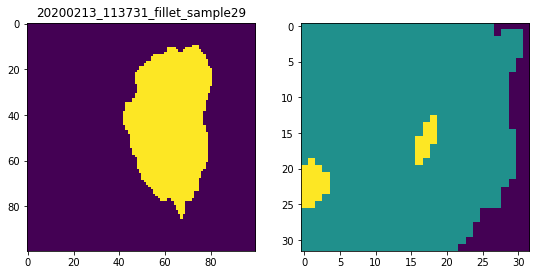

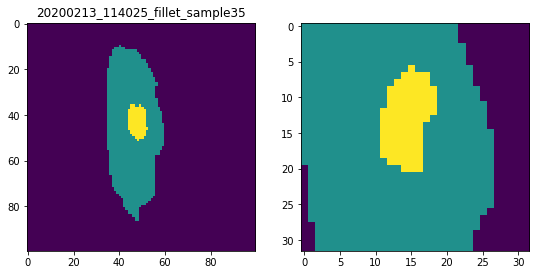

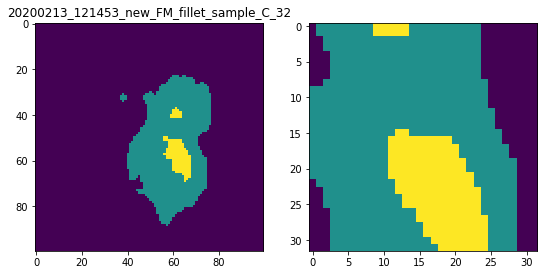

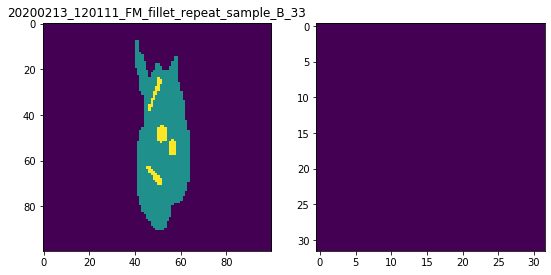

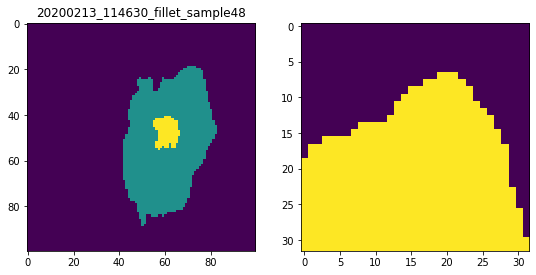

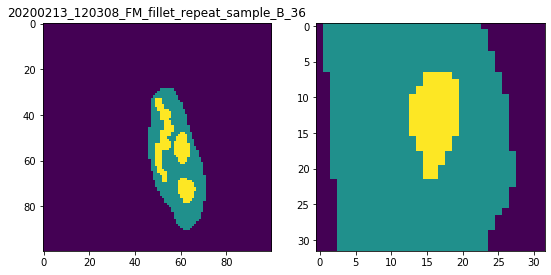

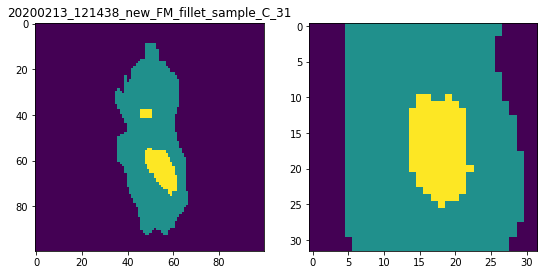

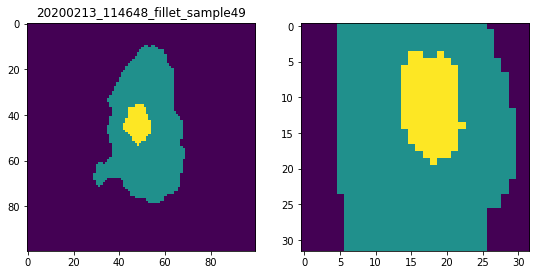

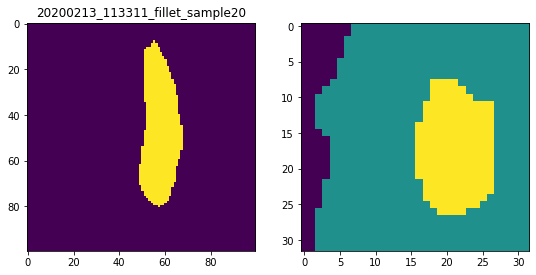

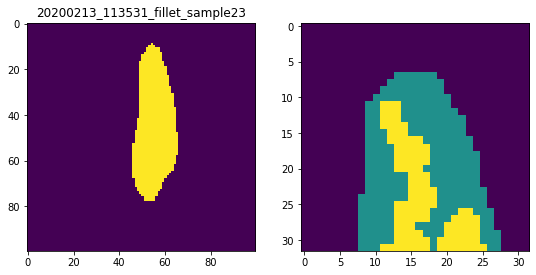

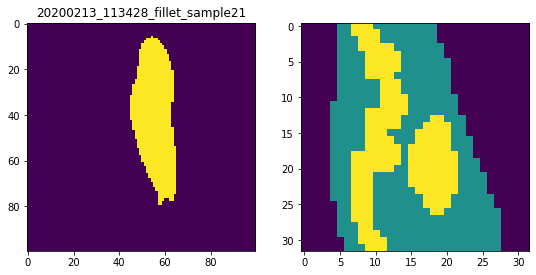

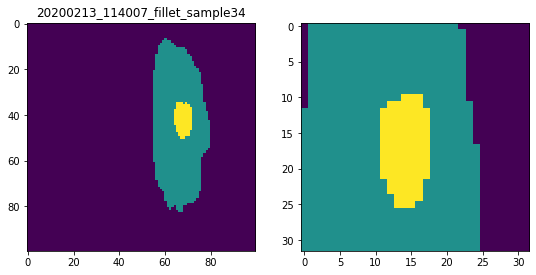

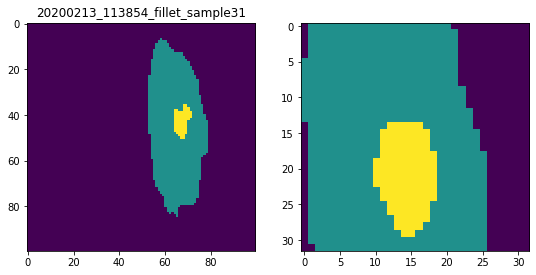

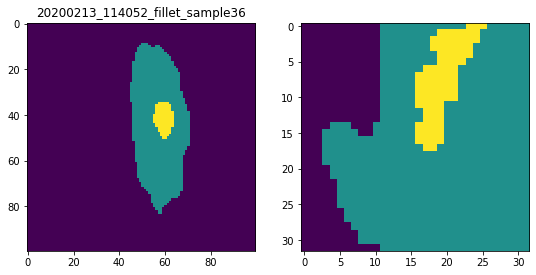

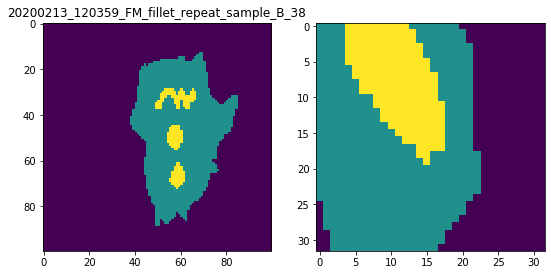

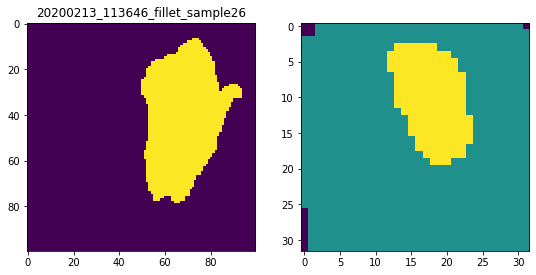

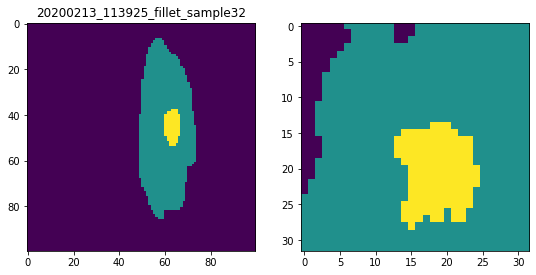

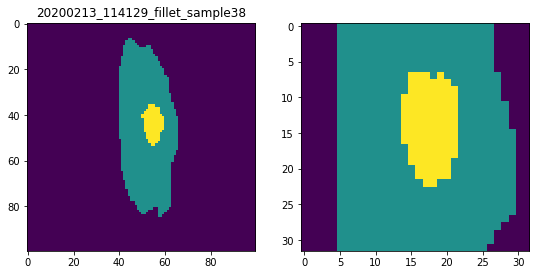

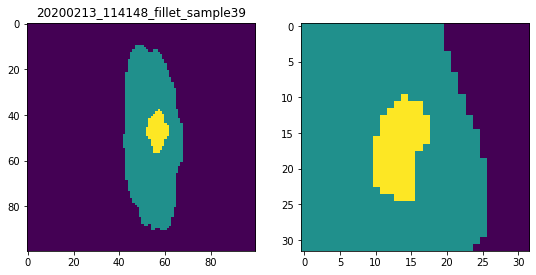

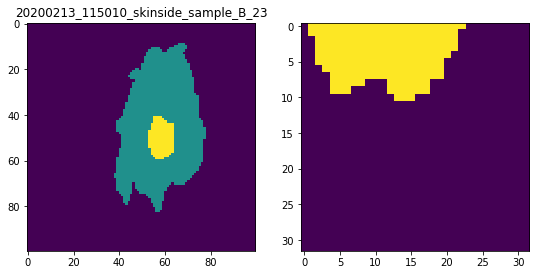

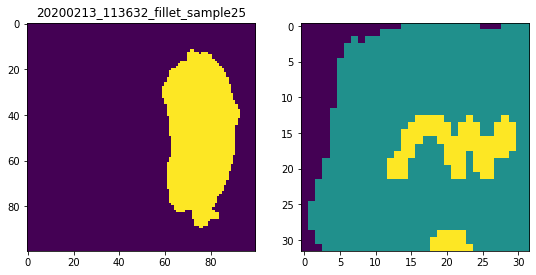

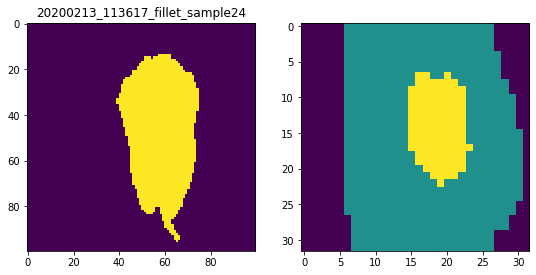

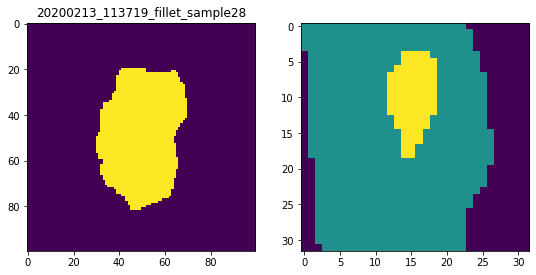

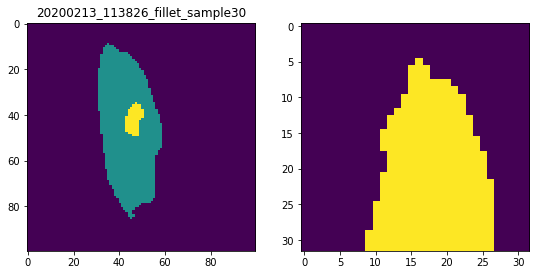

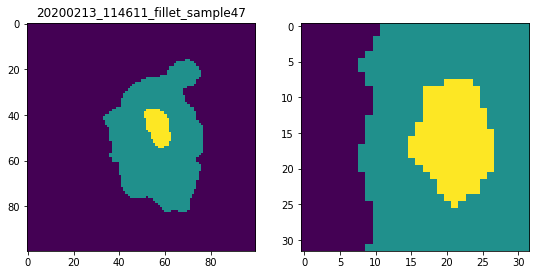

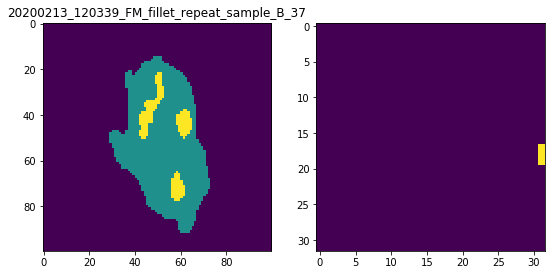

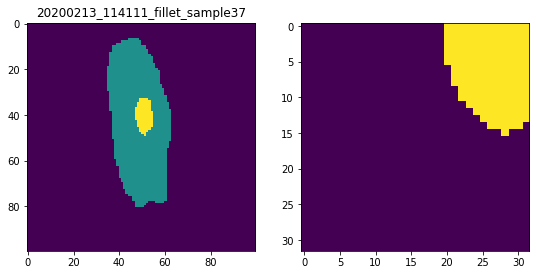

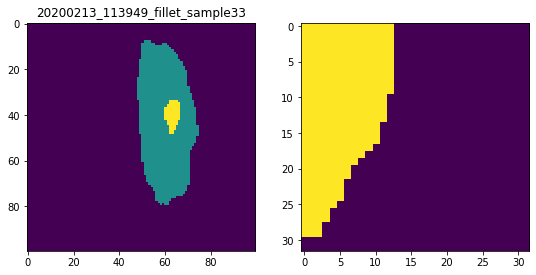

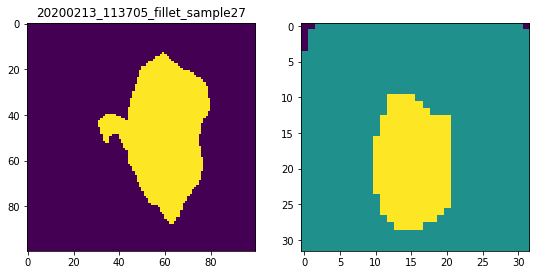

In [7]:
for i, name in enumerate(info):
    plt.figure(figsize=(9, 5))
    plt.subplot(121)
    plt.title(name)
    plt.imshow(np.squeeze(Y[i]))
    
    plt.subplot(122)
    plt.imshow(np.squeeze(enlarged_Y[i]))

In [5]:
import tensorflow as tf
tf.executing_eagerly()

True

In [26]:
# # Code from: https://github.com/keras-team/keras/issues/9395 @jpcenteno80
# def dice_coef(y_true, y_pred, n=3, smooth=1e-7):
#     '''
#     Dice coefficient for n categories.
#     Pass to model as metric during compile statement
#     '''
#     print(f'y_true.shape {y_true.shape}, y_pred.shape {y_pred.shape}')
#     # TODO: Inspect the output of print(np.unique(y_true)) .numpy()
# #     print(f'y_true {np.unique(tf.make_ndarray(tf.make_tensor_proto(K.flatten(y_true))))}')
# #     print(f'y_pred {np.unique(tf.make_ndarray(tf.make_tensor_proto(K.flatten(y_pred))))}')
#     y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=n)) # This causes the Error: Incompatible shapes: [61440] vs. [40960]
#     y_pred_f = K.flatten(y_pred)
#     print(f'y_true_f.shape {y_true_f.shape}, y_pred_f.shape {y_pred_f.shape}')
#     intersect = K.sum(y_true_f * y_pred_f, axis=-1)
#     denom = K.sum(y_true_f + y_pred_f, axis=-1)
#     print(f'intersect {intersect}, denom {denom}, smooth {smooth}')
#     return K.mean((2. * intersect / (denom + smooth)))

# unet = mypackage.MyUnet.UNet(X_train, Y_train, loss_func=dice_coef)
# # unet.summary()
# unet.train(batch_size=20, epochs=30, monitor='val_accuracy', metrics=['accuracy'], validation_split=0.1)

X_input (166, 32, 32, 208, 1), Y_input (166, 32, 32, 3)
Train on 149 samples, validate on 17 samples
Epoch 1/30
140/149 [===========================>..] - ETA: 0s - loss: 4.8871 - accuracy: 0.6315
Epoch 00001: val_accuracy improved from -inf to 0.72501, saving model to best-model.hdf5
149/149 [==============================] - 10s 70ms/sample - loss: 4.6085 - accuracy: 0.6450 - val_loss: 7.3457 - val_accuracy: 0.7250
Epoch 2/30
140/149 [===========================>..] - ETA: 0s - loss: 0.2748 - accuracy: 0.8275
Epoch 00002: val_accuracy improved from 0.72501 to 0.76224, saving model to best-model.hdf5
149/149 [==============================] - 8s 55ms/sample - loss: 0.2744 - accuracy: 0.8271 - val_loss: 7.2660 - val_accuracy: 0.7622
Epoch 3/30
140/149 [===========================>..] - ETA: 0s - loss: 0.2630 - accuracy: 0.8459
Epoch 00003: val_accuracy improved from 0.76224 to 0.77378, saving model to best-model.hdf5
149/149 [==============================] - 8s 55ms/sample - loss: 0.2

Epoch 27/30
140/149 [===========================>..] - ETA: 0s - loss: 0.1169 - accuracy: 0.9505
Epoch 00027: val_accuracy improved from 0.89821 to 0.90085, saving model to best-model.hdf5
149/149 [==============================] - 8s 54ms/sample - loss: 0.1176 - accuracy: 0.9485 - val_loss: 0.1674 - val_accuracy: 0.9009
Epoch 28/30
140/149 [===========================>..] - ETA: 0s - loss: 0.1117 - accuracy: 0.9501
Epoch 00028: val_accuracy improved from 0.90085 to 0.90125, saving model to best-model.hdf5
149/149 [==============================] - 8s 54ms/sample - loss: 0.1114 - accuracy: 0.9506 - val_loss: 0.1381 - val_accuracy: 0.9013
Epoch 29/30
140/149 [===========================>..] - ETA: 0s - loss: 0.1065 - accuracy: 0.9521
Epoch 00029: val_accuracy improved from 0.90125 to 0.90682, saving model to best-model.hdf5
149/149 [==============================] - 8s 54ms/sample - loss: 0.1076 - accuracy: 0.9503 - val_loss: 0.1357 - val_accuracy: 0.9068
Epoch 30/30
140/149 [==========

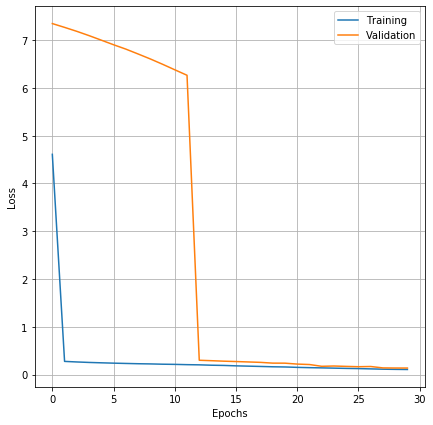

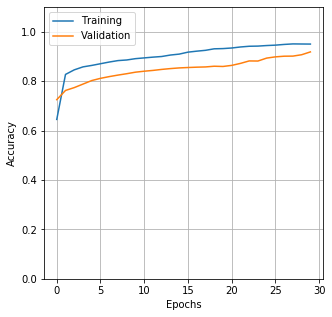

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     29249
           1       0.95      0.95      0.95     39092
           2       0.94      0.58      0.72      5387

    accuracy                           0.94     73728
   macro avg       0.94      0.84      0.88     73728
weighted avg       0.94      0.94      0.94     73728



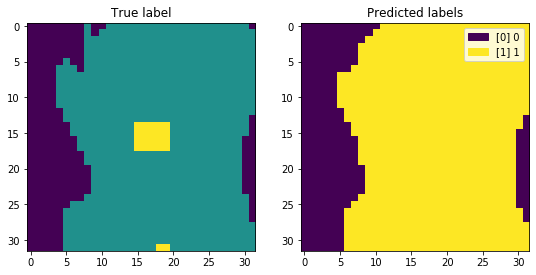

In [40]:
# Test the adaptivce loss -> https://github.com/NVIDIA/DeepLearningExamples/blob/master/TensorFlow/Segmentation/UNet_Industrial/utils/losses.py
import tensorflow.keras.backend as K

def reconstruction_x_entropy(y_pred, y_true, from_logits=False):
    return tf.reduce_mean(input_tensor=tf.keras.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=from_logits))

# Improved alternative the Dice_Loss -> https://arxiv.org/pdf/1810.07842.pdf
def dice_coe(y_pred, y_true, loss_type='jaccard', smooth=1.):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.
    Parameters
    -----------
    y_true : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    y_pred : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background),
            dice = ```smooth/(small_value + smooth)``,
            then if smooth is very small, dice close to 0 (even the image values lower than the threshold),
            so in this case, higher smooth can have a higher dice.
    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__
    """

    y_true_f = tf.compat.v1.layers.flatten(y_true)
    y_pred_f = tf.compat.v1.layers.flatten(y_pred)

    intersection = tf.reduce_sum(input_tensor=y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(input_tensor=tf.square(y_pred_f)) + tf.reduce_sum(input_tensor=tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(input_tensor=y_pred_f) + tf.reduce_sum(input_tensor=y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)


def adaptive_loss(y_pred, y_true, switch_at_threshold=0.3, loss_type='jaccard'):

    dice_loss = 1 - dice_coe(y_pred=y_pred, y_true=y_true, loss_type=loss_type, smooth=1.)

    return tf.cond(
        pred=dice_loss < switch_at_threshold,
        true_fn=lambda: dice_loss,
        false_fn=lambda: reconstruction_x_entropy(y_pred=y_pred, y_true=y_true, from_logits=False)
    )

unet = mypackage.MyUnet.UNet(X_train, Y_train, loss_func=adaptive_loss)
# unet.summary()
unet.train(batch_size=20, epochs=30, monitor='val_accuracy', metrics=['accuracy'], validation_split=0.1)
unet.plot_training_results()
unet.predict(X_test, Y_labels=Y_test);

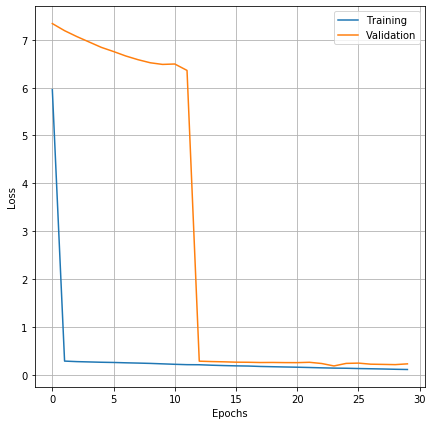

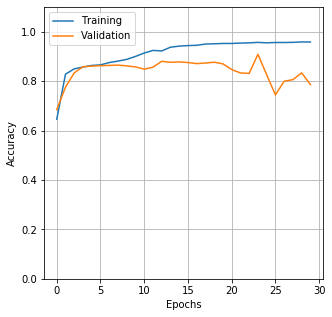

              precision    recall  f1-score   support

           0       1.00      0.89      0.94     29249
           1       0.89      0.99      0.94     39092
           2       0.82      0.61      0.70      5387

    accuracy                           0.92     73728
   macro avg       0.90      0.83      0.86     73728
weighted avg       0.93      0.92      0.92     73728



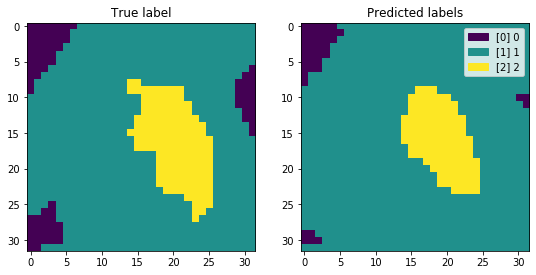

In [39]:
unet.plot_training_results()
unet.predict(X_test, Y_labels=Y_test);

X_input (166, 32, 32, 208, 1), Y_input (166, 32, 32, 3)
Train on 149 samples, validate on 17 samples
Epoch 1/30
140/149 [===========================>..] - ETA: 0s - loss: 2.2407 - accuracy: 0.5910 - dice_coef2: 0.4733
Epoch 00001: val_dice_coef2 improved from -inf to 0.44967, saving model to best-model.hdf5
149/149 [==============================] - 10s 69ms/sample - loss: 2.2342 - accuracy: 0.6010 - dice_coef2: 0.4801 - val_loss: 2.3110 - val_accuracy: 0.8297 - val_dice_coef2: 0.4497
Epoch 2/30
140/149 [===========================>..] - ETA: 0s - loss: 2.0709 - accuracy: 0.8392 - dice_coef2: 0.5541
Epoch 00002: val_dice_coef2 improved from 0.44967 to 0.46498, saving model to best-model.hdf5
149/149 [==============================] - 8s 55ms/sample - loss: 2.0701 - accuracy: 0.8399 - dice_coef2: 0.5550 - val_loss: 2.2888 - val_accuracy: 0.8224 - val_dice_coef2: 0.4650
Epoch 3/30
140/149 [===========================>..] - ETA: 0s - loss: 2.0041 - accuracy: 0.8758 - dice_coef2: 0.5816
Ep

Epoch 23/30
140/149 [===========================>..] - ETA: 0s - loss: 1.3545 - accuracy: 0.9540 - dice_coef2: 0.7837
Epoch 00023: val_dice_coef2 improved from 0.68185 to 0.69425, saving model to best-model.hdf5
149/149 [==============================] - 8s 55ms/sample - loss: 1.3546 - accuracy: 0.9542 - dice_coef2: 0.7841 - val_loss: 1.9125 - val_accuracy: 0.7073 - val_dice_coef2: 0.6943
Epoch 24/30
140/149 [===========================>..] - ETA: 0s - loss: 1.3259 - accuracy: 0.9581 - dice_coef2: 0.7904
Epoch 00024: val_dice_coef2 improved from 0.69425 to 0.71740, saving model to best-model.hdf5
149/149 [==============================] - 8s 54ms/sample - loss: 1.3256 - accuracy: 0.9585 - dice_coef2: 0.7906 - val_loss: 1.8565 - val_accuracy: 0.7177 - val_dice_coef2: 0.7174
Epoch 25/30
140/149 [===========================>..] - ETA: 0s - loss: 1.3275 - accuracy: 0.9564 - dice_coef2: 0.7933
Epoch 00025: val_dice_coef2 improved from 0.71740 to 0.72742, saving model to best-model.hdf5
149/

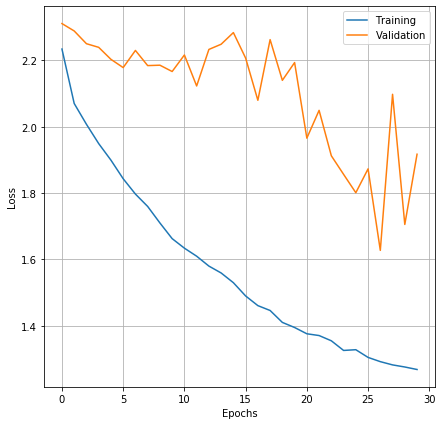

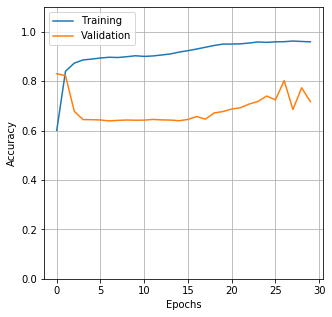

              precision    recall  f1-score   support

           0       1.00      0.38      0.55     29249
           1       0.91      0.99      0.95     39092
           2       0.17      0.65      0.27      5387

    accuracy                           0.72     73728
   macro avg       0.69      0.67      0.59     73728
weighted avg       0.89      0.72      0.74     73728



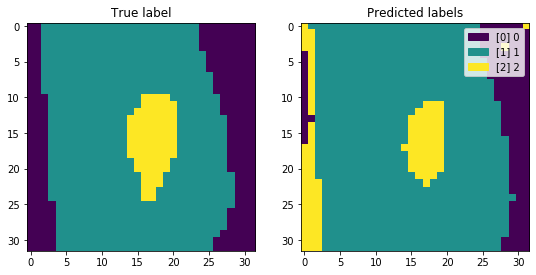

In [14]:
import tensorflow.keras.backend as K

# Code from: https://github.com/keras-team/keras/issues/9395 @jpcenteno80
def dice_coef(y_true, y_pred, n=3, smooth=1e-7):
    '''
    Dice coefficient for n categories.
    Pass to model as metric during compile statement
    '''
    print(f'y_true.shape {y_true.shape}, y_pred.shape {y_pred.shape}')
    # TODO: Inspect the output of print(np.unique(y_true))
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=n)) # This causes the Error: Incompatible shapes: [61440] vs. [40960]
    y_pred_f = K.flatten(y_pred)
    print(f'y_true_f.shape {y_true_f.shape}, y_pred_f.shape {y_pred_f.shape}')
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    print(f'intersect {intersect}, denom {denom}, smooth {smooth}')
    return K.mean((2. * intersect / (denom + smooth)))


def dice_coef_loss(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_coef(y_true, y_pred)

######################################

# Code from: https://github.com/keras-team/keras/issues/9395
# Ref: salehi17, "Twersky loss function for image segmentation using 2D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    print(f'y_true.type {type(y_true)}, y_pred.type {type(y_pred)}')
    print(f'y_true.shape {y_true.shape}, y_pred.shape {y_pred.shape}')
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # probability that voxels are class i
    p1 = ones-y_pred # probability that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl - T

#######################################
# TODO: Make this multi class classification, at the moment this is only binary...
# Code from: https://www.kaggle.com/qlasty/unet-tf2-dataset-channels-focal-tversky-loss
def dice_coef2(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#https://github.com/nabsabraham/focal-tversky-unet
def tversky(y_true, y_pred, smooth=1):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky_loss_r(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)


# https://github.com/nabsabraham/focal-tversky-unet/issues/3
def class_tversky(y_true, y_pred):
    smooth = 1

    y_true = K.permute_dimensions(y_true, (3,1,2,0))
    y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.5 # 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

# channels sensitive loss function
def focal_tversky_loss_c(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.5 # 0.75
    return K.sum(K.pow((1-pt_1), gamma))
########################################

# The default 'accuracy' calculates how often predictions equals labels.
unet = mypackage.MyUnet.UNet(X_train, Y_train, loss_func=focal_tversky_loss_c)
# unet.summary()
unet.train(batch_size=20, epochs=30, monitor='val_dice_coef2', metrics=['accuracy', dice_coef2], validation_split=0.1)
unet.plot_training_results()
unet.predict(X_test, Y_labels=Y_test);

In [13]:
Y_train.dtype

dtype('float64')

In [39]:
keep_index = []
for i in range(len(Y_train)):
#     print(i, np.unique(Y_train))
    if len(np.unique(Y_train[i])) > 2:
        keep_index.append(i)
print(keep_index)

[0, 1, 3, 4, 6, 7, 8, 9, 10, 12, 13, 14, 16, 19, 20, 21, 22, 28, 30, 31, 32, 34, 35, 36, 37, 40, 42, 43, 45, 47, 48, 49, 50, 51, 53, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 69, 71, 72, 75, 76, 77, 78, 80, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96, 98, 100, 103, 106, 109, 112, 114, 115, 116, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 137, 138, 140, 141, 143, 144, 145, 148, 149, 150, 151, 153, 154, 155, 156, 159, 160, 162, 164, 165]


In [44]:
np.unique(Y_train[2])

array([0.])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



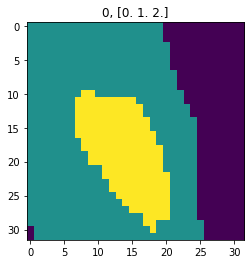

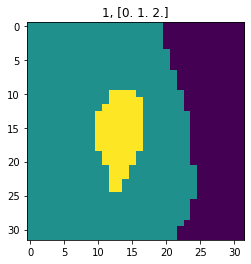

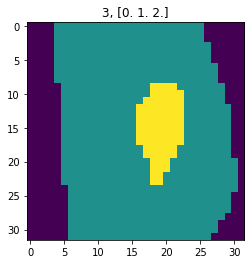

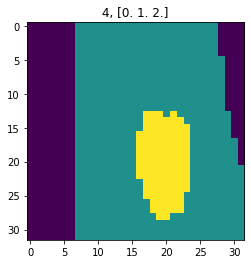

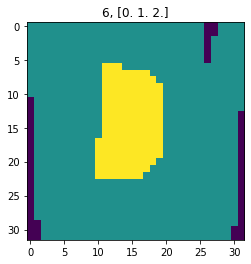

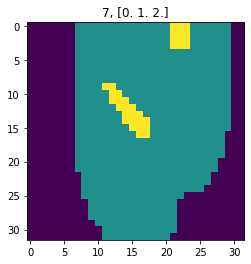

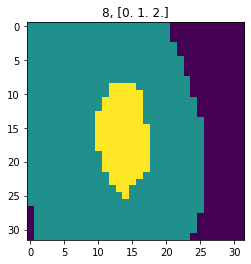

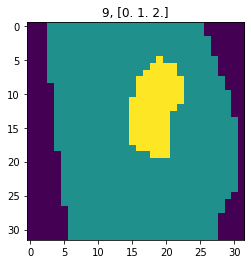

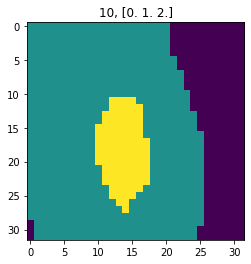

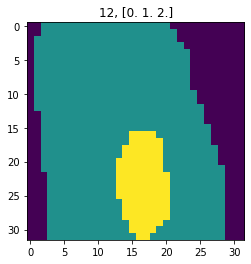

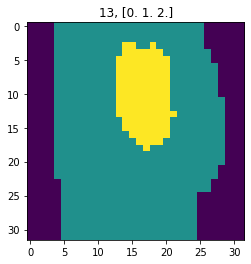

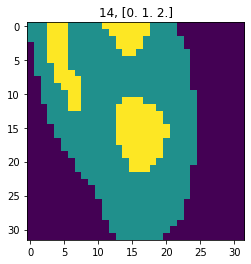

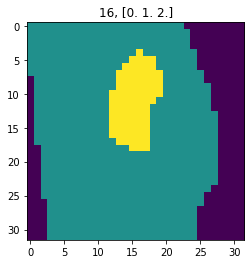

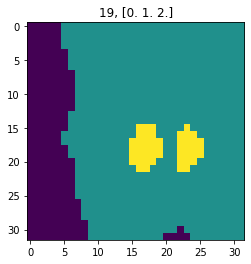

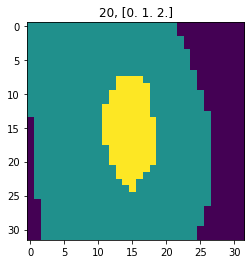

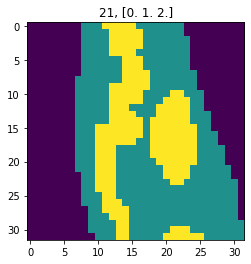

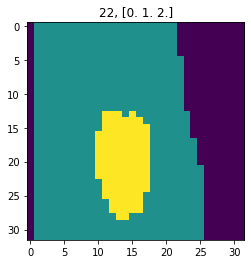

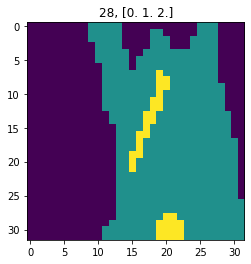

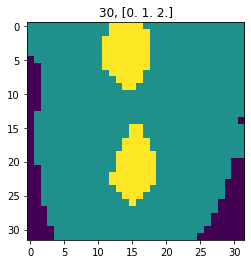

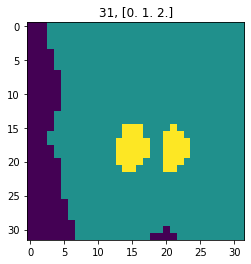

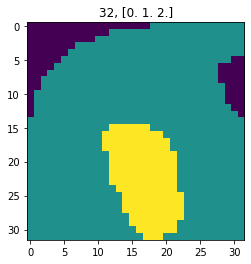

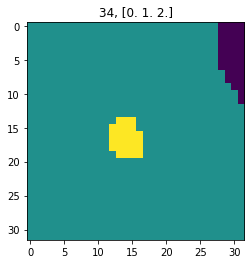

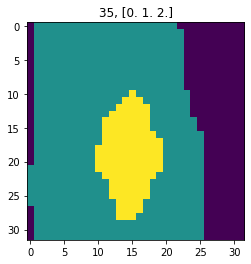

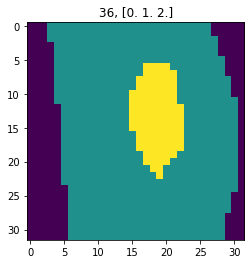

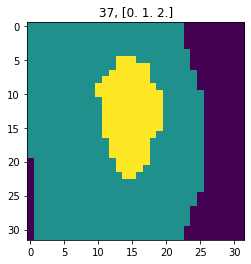

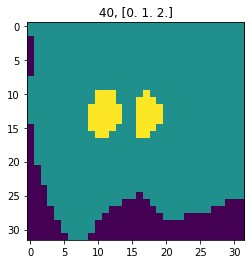

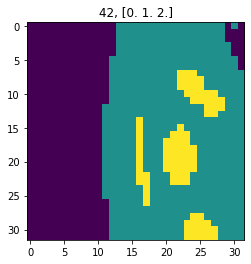

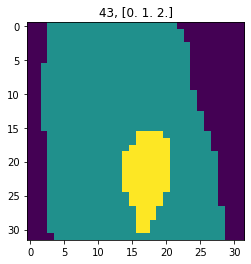

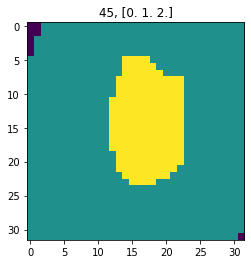

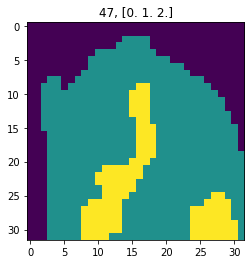

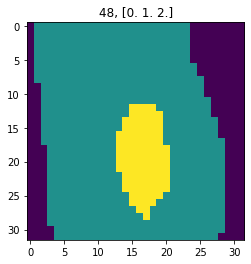

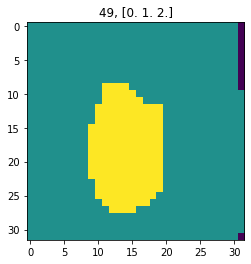

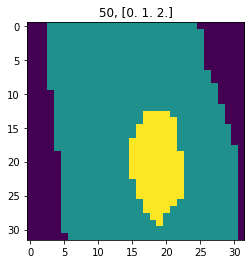

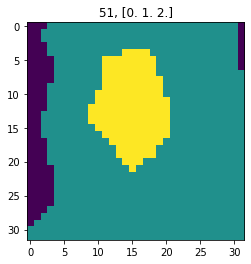

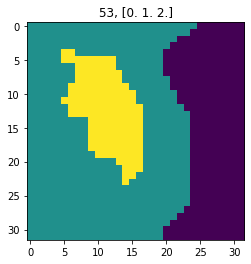

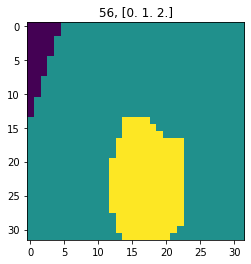

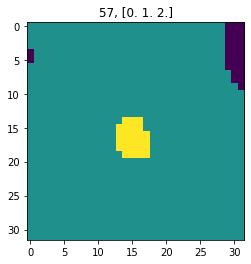

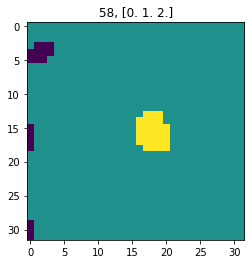

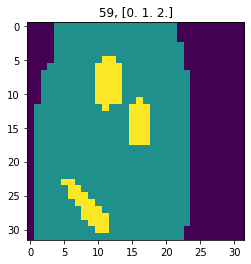

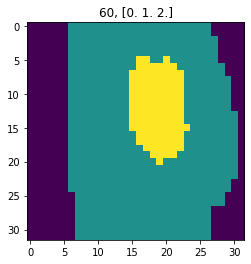

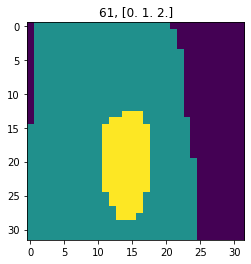

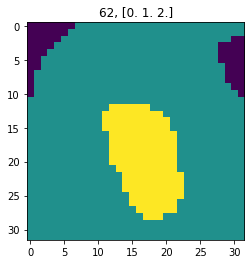

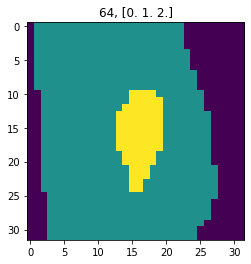

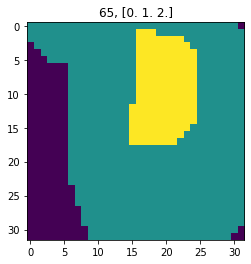

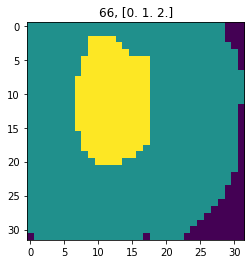

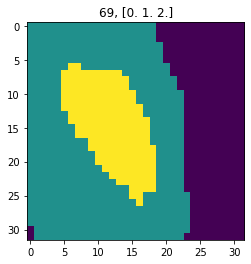

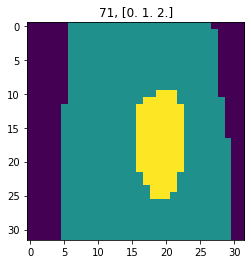

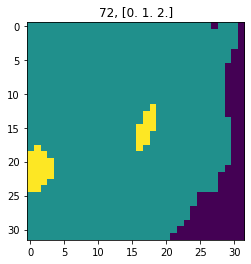

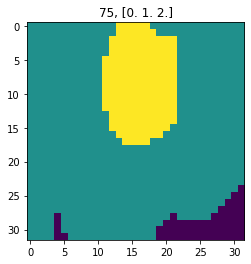

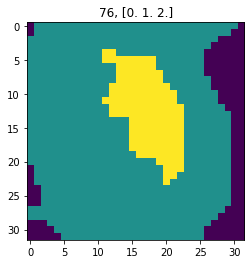

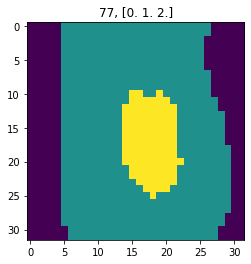

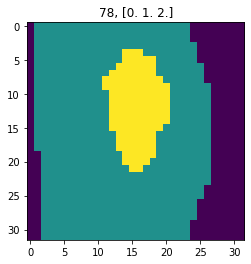

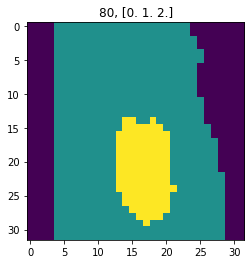

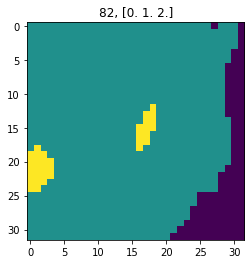

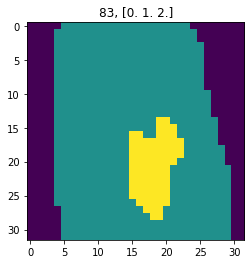

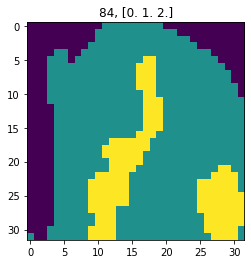

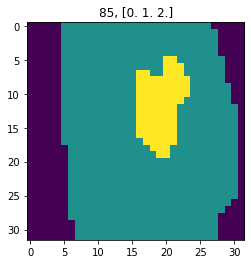

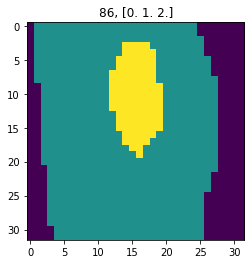

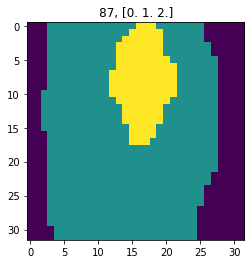

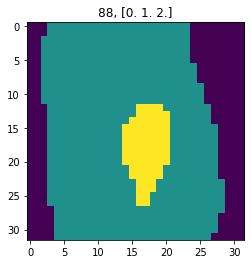

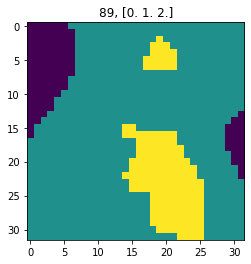

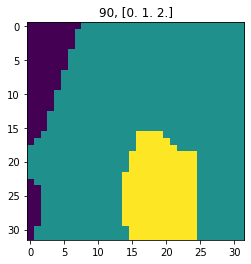

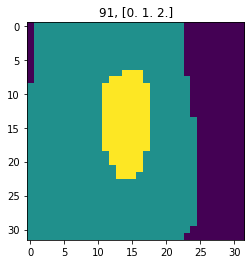

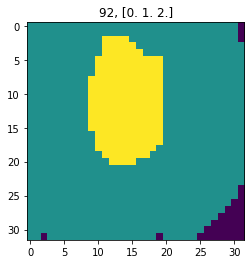

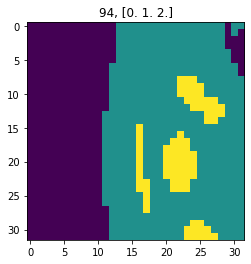

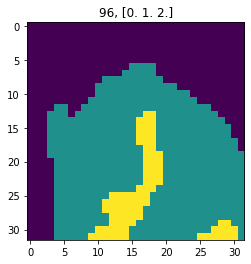

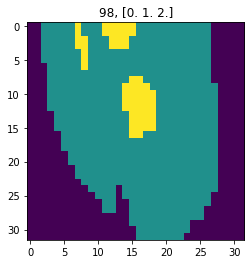

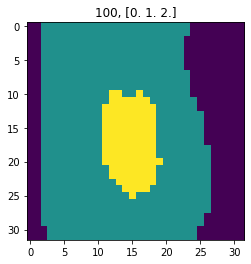

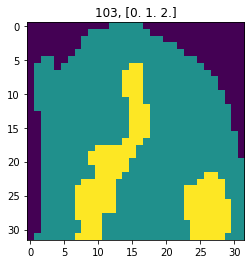

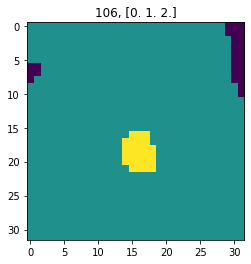

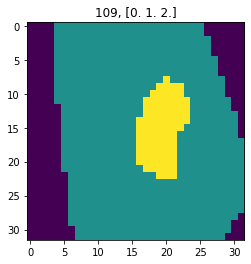

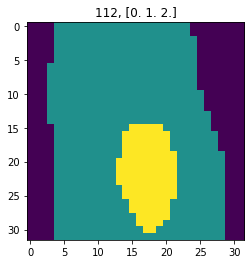

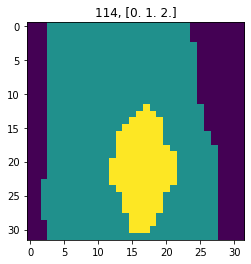

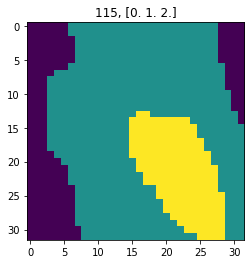

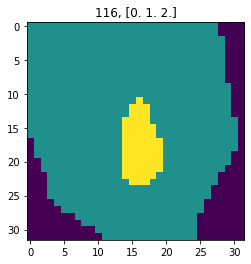

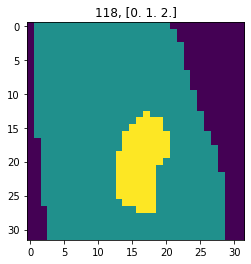

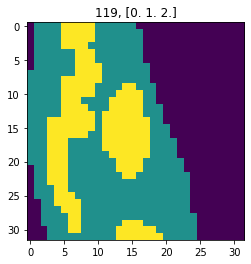

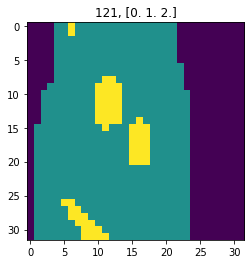

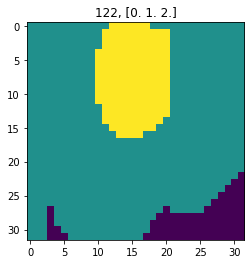

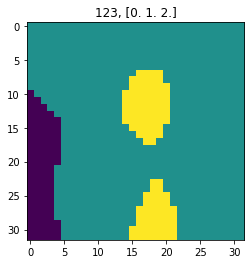

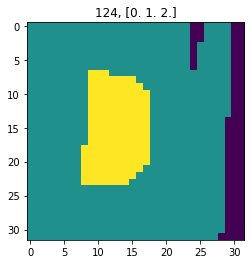

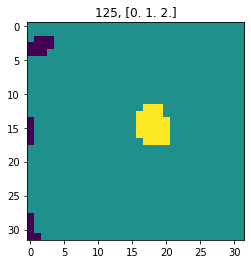

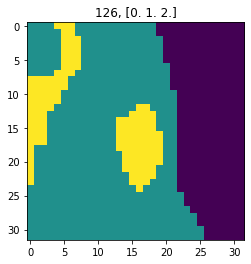

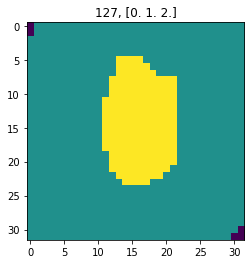

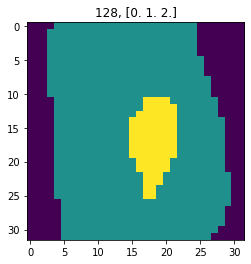

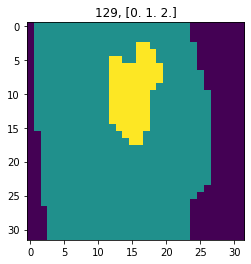

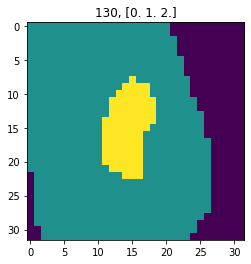

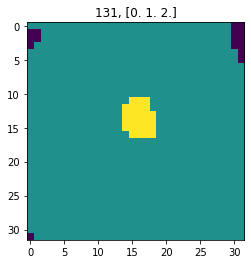

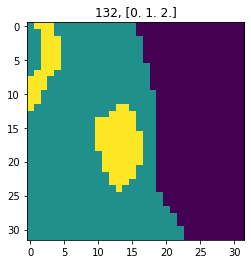

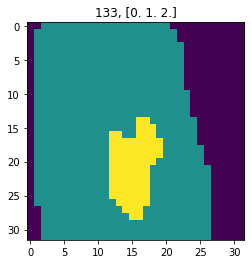

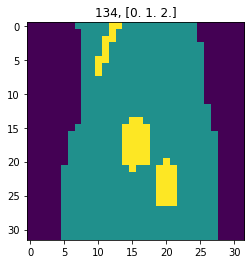

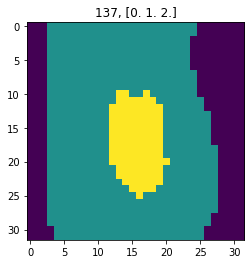

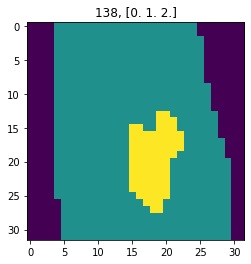

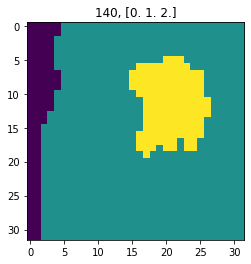

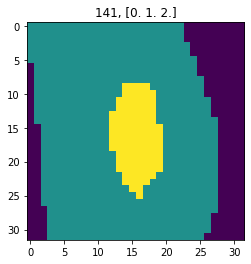

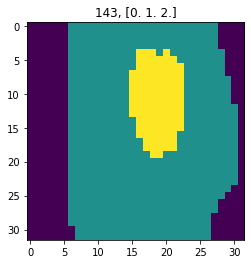

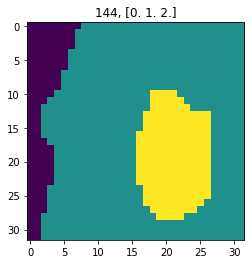

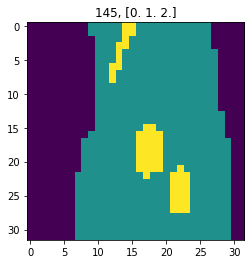

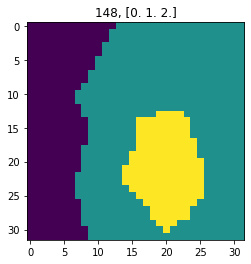

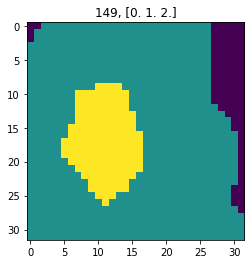

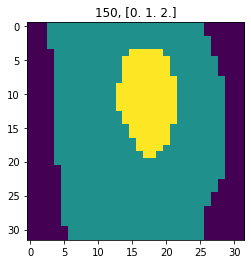

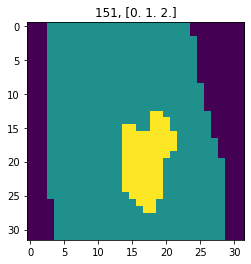

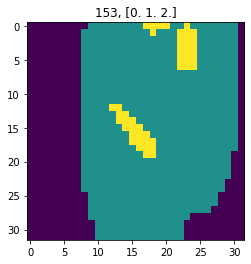

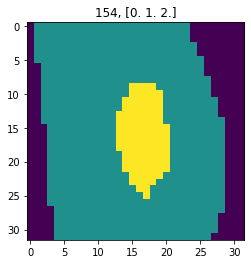

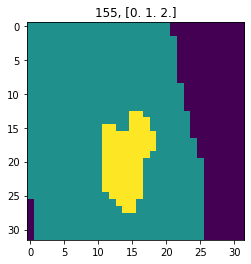

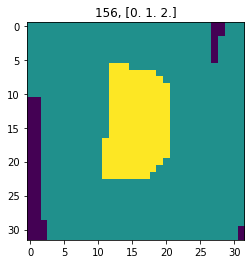

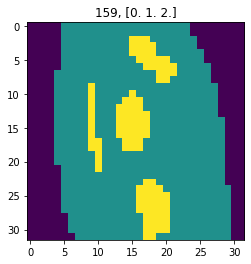

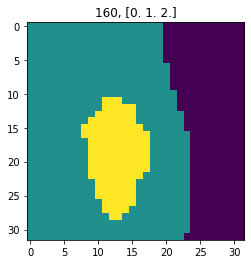

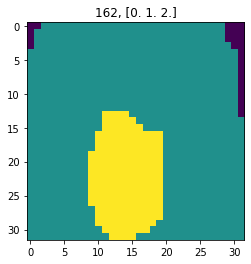

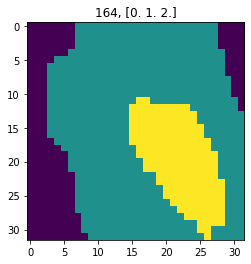

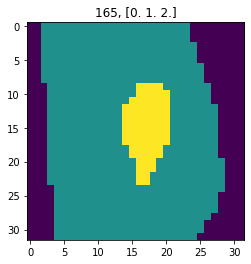

In [43]:
for i in keep_index: #range(len(Y_train)):
    plt.figure()
    plt.title(f'{i}, {np.unique(Y_train[i])}')
    plt.imshow(np.squeeze(Y_train[i]))